In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile


onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_paths = dict(
    SPR45 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-09 - STEP simulation for wide radiation front",
    V10 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-12 - Ryoko V10\step0_A5e21spr",
    # DTT = r"C:\Users\mikek\OneDrive\Project\DLS\from_matteo\2024-09-13 - DTT cases\20230906.Ne_1e20.SOLEDGE2D.Pump_0.9875")
)


In [292]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for side in ["ol", "il"]:
        eqb[case][side] = dict()
        eqb_alt[case][side] = dict()
        for i in range(10):
            eqb[case][side][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], region = {"ol":"outer_lower", "il":"inner_lower"}[side], sepadd = 1)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][side][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    
        
# file_write(eqb, "equilibrium.pkl")

# Read SOLPS case

In [253]:
store_slc = {}

for case in balance_paths:
    store_slc[case] = SOLPScase(balance_paths[case])
    store_slc[case].get_species()
    store_slc[case].get_impurity_stats("Ar", all_states = True)

Saving all states
Added total radiation, density and fraction for Ar
Saving all states
Added total radiation, density and fraction for Ar


# Read radas

In [25]:
rd = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")
# ds = ds.sel(dim_electron_density=1e20, method="nearest")

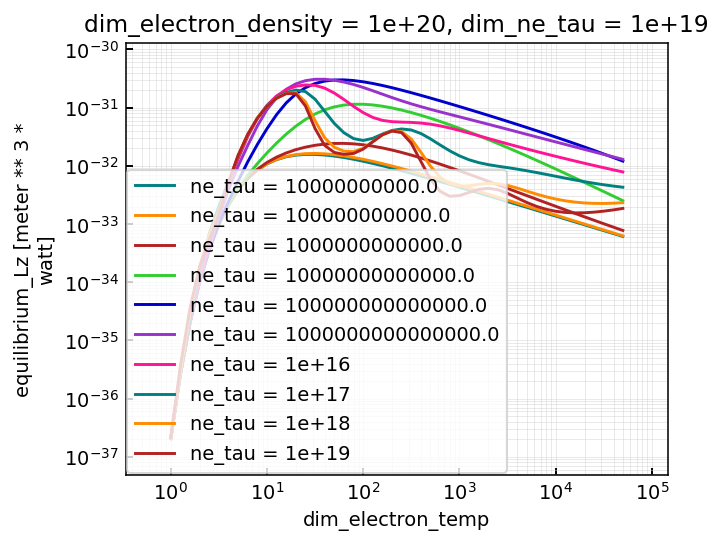

In [450]:
fig, ax = plt.subplots()

for i, neTau in enumerate(rd["ne_tau"]):
    # print(neTau)
    data = rd["equilibrium_Lz"].sel(dim_ne_tau = neTau, dim_electron_density=1e20, method="nearest")
    data.plot(ax = ax, label = f"ne_tau = {neTau}")
    
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# Run DLS for SPR45 outer

In [185]:
%matplotlib inline

### SPR45 cooling curve

Text(0.5, 1.0, 'Cooling curves: SOLPS vs. DLS')

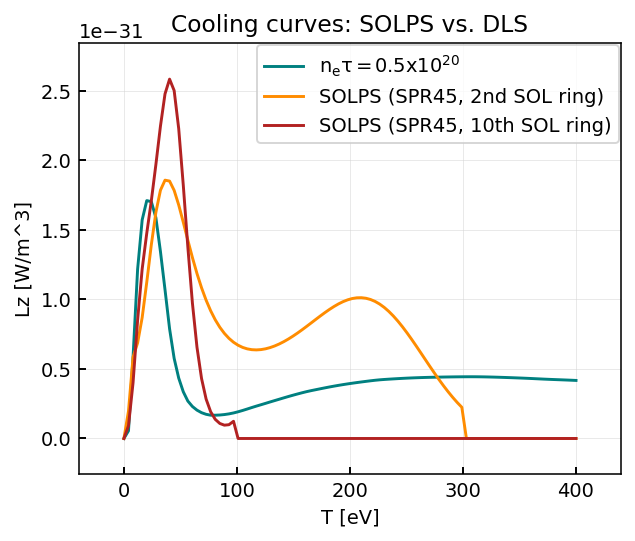

In [248]:
def LfuncSPR45(sepadd:int, T: float) -> float:
    """
    Custom cooling curve, just paste coefficients here
    """

    if sepadd == 1:
        coeffs = np.array(
            [
                0.32923974,
                -3.59703885,
                14.46646729,
                -23.94756159,
                4.79511933,
                29.65288639,
                -20.48365376,
                -14.42773907,
                11.0865708,
                7.35418502,
                -36.43010748,
            ]
        )
        upper_lim = 300
        
    elif sepadd == 9:
        coeffs = np.array([  5.28423922, -36.74959101,  92.67541517, -85.85515048,
       -26.72882023,  94.29311184, -28.39796852, -31.07978774,
        13.33243312,   8.43714703, -36.42474764])
        
        upper_lim = 100
        
    else:
        raise Exception()
    
    
    
    if type(T) != np.float64:
        raise ValueError("T must be a float")
    
    logT = np.log10(T)
    
    fit = lambda x: 10**np.polyval(coeffs, logT)
    
    if T > upper_lim:
        # bound = fit(np.log10(upper_lim))

        # print(f"{T:.2f} above limit, returning {bound:.2e}")
        return 0

    elif T < 0.5:
        return 0
    else:
        return fit(logT)
    
    
T = np.linspace(0, 400, 100)

fig, ax = plt.subplots()
ax.plot(T, LfuncKallenbach("Ar")(T), label = "$n_e \\tau = 0.5 x 10^{20}$")
ax.plot(T, [LfuncSPR45(1, temp) for temp in T], label = "SOLPS (SPR45, 2nd SOL ring)")
ax.plot(T, [LfuncSPR45(9, temp) for temp in T], label = "SOLPS (SPR45, 10th SOL ring)")
ax.set_xlabel("T [eV]")
ax.set_ylabel("Lz [W/m^3]")
ax.legend()
ax.set_title("Cooling curves: SOLPS vs. DLS")
# ax.set_yscale("log")


## Sepadd 1

Solving...6.00...Complete in 1.4 seconds
[4.693862809818573e+19]


(0.0, 20.0)

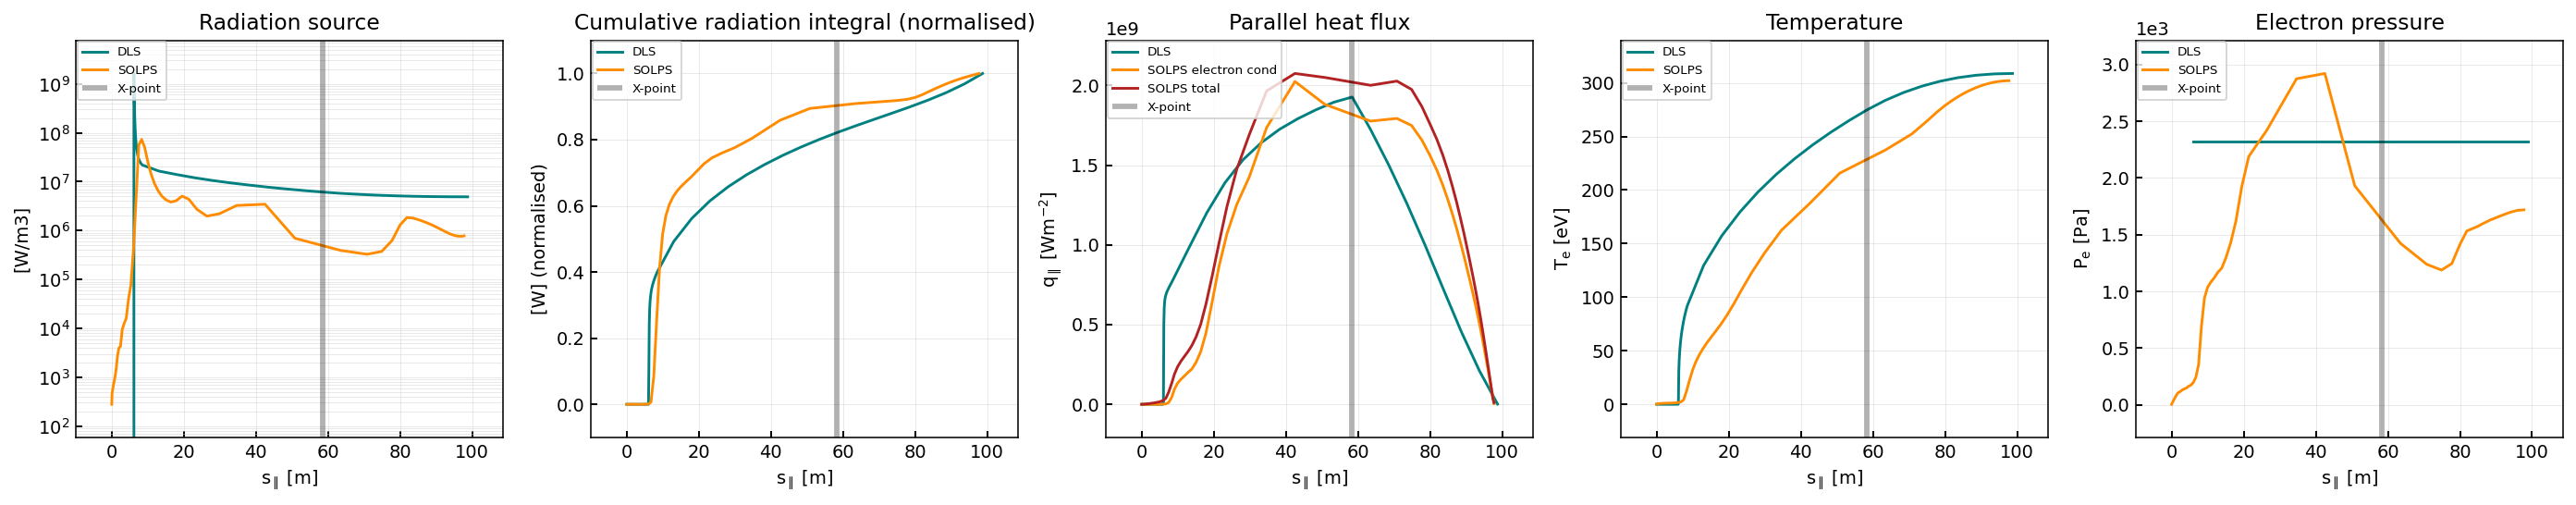

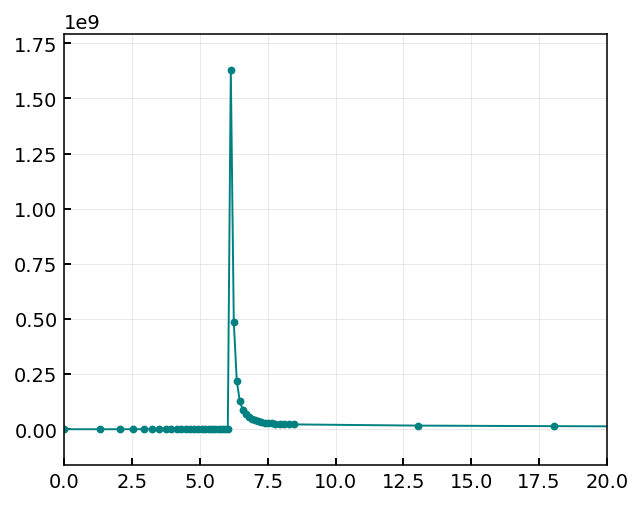

In [322]:
case = "SPR45"
sepadd = 1
slc = store_slc[case]

# d = eqb[case]["ol"][sepadd]
d = eqb_alt[case]["ol"][sepadd]
# d.scale_Lc(scale_factor=1.1)

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
    # "Lfunc": lambda x: LfuncSPR45(1, x),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

#### Original average Cz and qpar
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 

#### Tune peak qpar
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 2.330e9 

#### Tune qpar to same Tu
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 * 1

#### Change kappa0
constants_default["kappa0"] = 800
constants_default["qpllu0"] = 2.45e9

#### Change kappa0, tune after LfuncSPR45
constants_default["kappa0"] = 800
constants_default["qpllu0"] = 2.2e9

SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [6],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGrid = True,
            dynamicGridRefinementRatio = 10,
            dynamicGridRefinementWidth = 2,
            dynamicGridDiagnosticPlot = False)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])


comp = compare_SOLPS_DLS(slc, out, region = "outer_lower", sepadd = sepadd)

comp.plot(["Qrad", "Cumrad", "qpar", "Te", "Pe"], normalise_radiation = True)

fig, ax =plt.subplots()
ax.plot(out["Sprofiles"][0], out["Rprofiles"][0], marker = "o", ms = 3, lw = 1)
ax.set_xlim(0,20)

In [299]:
dls = pd.DataFrame()
dls["Qrad"] = 
dls["Spar"] = 
dls["Spol"] = out["Spolprofiles"][0]
dls["Te"] = out["Tprofiles"][0]
dls["qpar"] = out["Qprofiles"][0]
dls["Btot"] = out["Btotprofiles"][0]
dls["Ne"] = out["cvar"][0] * dls["Te"].iloc[-1] / dls["Te"]   ## Assuming cvar is ne
Xpoint = out["Xpoints"][0]
dls.loc[Xpoint, "Xpoint"] = 1

(0.0, 20.0)

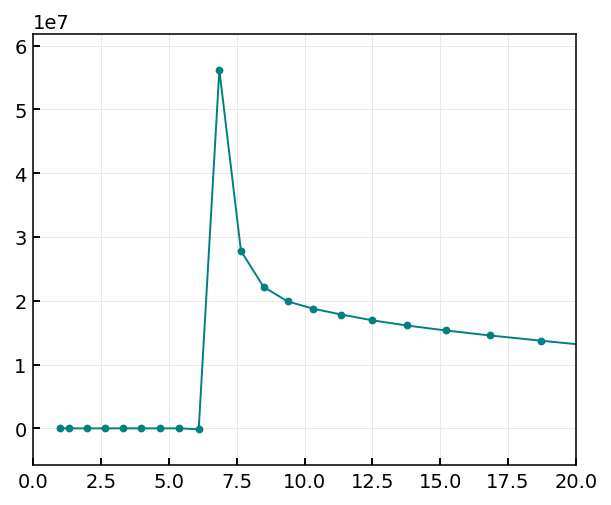

In [307]:

# ax.set_xscale("log")

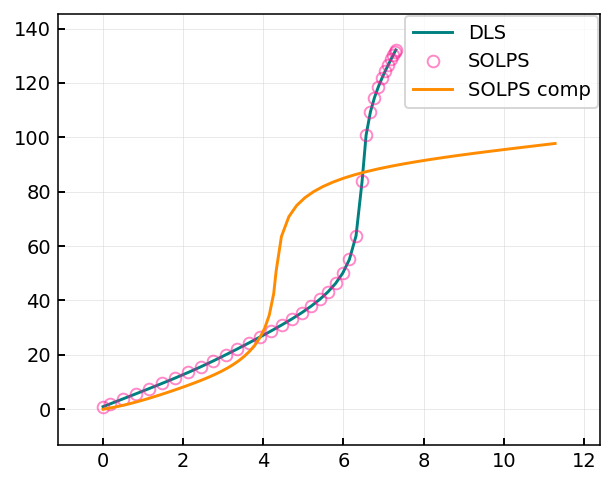

In [291]:
solps = pd.DataFrame()
s = eqb_alt["SPR45"]["ol"][1]

solps["Spar"] = s["S"]
solps["Spol"] = s["Spol"]
solps["R"] = s["R"]
solps["Z"] = s["Z"]
solps["Btot"] = s["Btot"]
solps["Bpol"] = s["Bpol"]

solps_comp = slc.get_1d_poloidal_data(["Btot", "hx", "vol", "R", "Te", "RAr", "ne", "fhex_cond", "fhx_total"], 
                                  sepadd = 1, region = "outer_lower", target_first = True)


for param in ["Spar"]:
    fig, ax = plt.subplots()
    ax.plot(dls["Spol"], solps[param], label = "DLS")
    ax.plot(solps["Spol"], solps[param], label = "SOLPS", marker = "o", markerfacecolor = "None", alpha = 0.5, lw = 0, c = "deeppink")
    # ax.plot(comp.solps["Spol"], comp.solps[param], label = "SOLPS comp")
    ax.plot(solps_comp["Spol"], solps_comp[param], label = "SOLPS comp")
    ax.legend()


## Back-calculate conduction

In [428]:
%matplotlib inline

Text(0.5, 1.0, 'Electron conductivity')

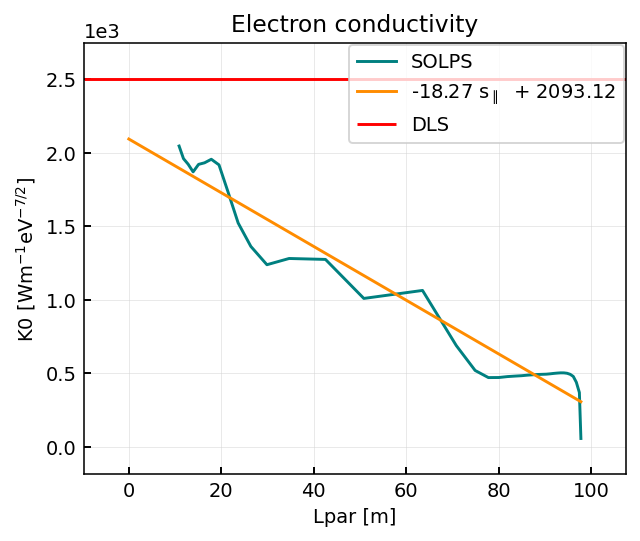

In [138]:
df = slc.get_1d_poloidal_data(["hx", "vol", "R", "Te", "RAr", "ne", "fhex_cond", "fhx_total"], 
                                  sepadd = 1, region = "outer_lower", target_first = True)

qpar = df["fhex_cond"] / df["apar"]
gradT = np.gradient(df["Te"], df["Spar"])
df["kappa0"] = qpar / (df["Te"]**(5/2) * gradT)

fig, ax = plt.subplots()
# ax.plot(df["Spar"], gradT)
# ax2 = ax.twinx()
# ax2.plot(df["Spar"], df["Te"])

dfx = df[df["Xpoint"]==1]
dfsol = df[df["Spar"] > 10]
ax.plot(dfsol["Spar"], dfsol["kappa0"], label = "SOLPS")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfsol["Spar"], dfsol["kappa0"])
kappa_interp = df["Spar"] * slope + intercept

ax.plot(df["Spar"], kappa_interp, label = f"{slope:.2f} $s_{{\parallel}}$  + {intercept:.2f}")

xlim = ax.get_xlim()
ax.hlines(2500, *xlim, color = "r", label = "DLS")
ax.set_xlim(xlim)
ax.legend()
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("K0 [$W m^{-1} eV^{-7/2}]$")
ax.set_title("Electron conductivity: 2nd SOL ring")
# ax.set_xlim(0, xlim[1])
# ax.set_yscale("log")

C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\77739923.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfsol = df[df["Spar"] > 20][df["Spar"] < 55]


Text(0.5, 1.0, 'Electron conductivity: 10th SOL ring')

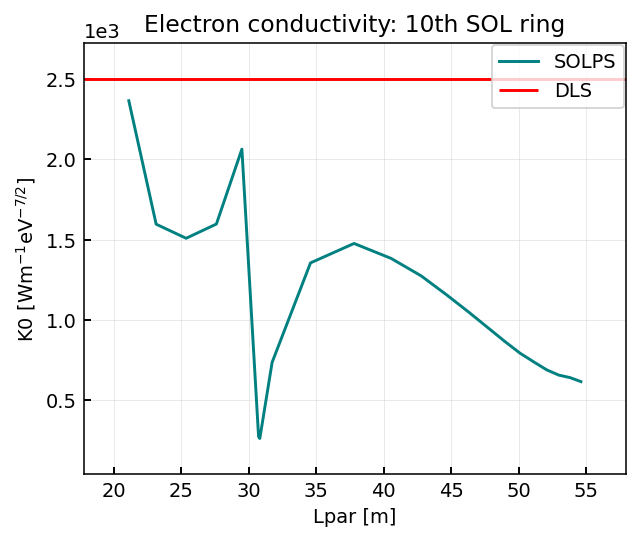

In [143]:
df = slc.get_1d_poloidal_data(["hx", "vol", "R", "Te", "RAr", "ne", "fhex_cond", "fhx_total"], 
                                  sepadd = 9, region = "outer_lower", target_first = True)

qpar = df["fhex_cond"] / df["apar"]
gradT = np.gradient(df["Te"], df["Spar"])
df["kappa0"] = qpar / (df["Te"]**(5/2) * gradT)

fig, ax = plt.subplots()
# ax.plot(df["Spar"], gradT)
# ax2 = ax.twinx()
# ax2.plot(df["Spar"], df["Te"])

dfx = df[df["Xpoint"]==1]
dfsol = df[df["Spar"] > 20][df["Spar"] < 55]
ax.plot(dfsol["Spar"], dfsol["kappa0"], label = "SOLPS")

xlim = ax.get_xlim()
ax.hlines(2500, *xlim, color = "r", label = "DLS")
ax.set_xlim(xlim)
ax.legend()
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("K0 [$W m^{-1} eV^{-7/2}]$")
ax.set_title("Electron conductivity: 10th SOL ring")
# ax.set_xlim(0, xlim[1])
# ax.set_yscale("log")

## Further sepadd

Solving...18.00...Complete in 1.0 seconds
[1.45213746814609e+19]


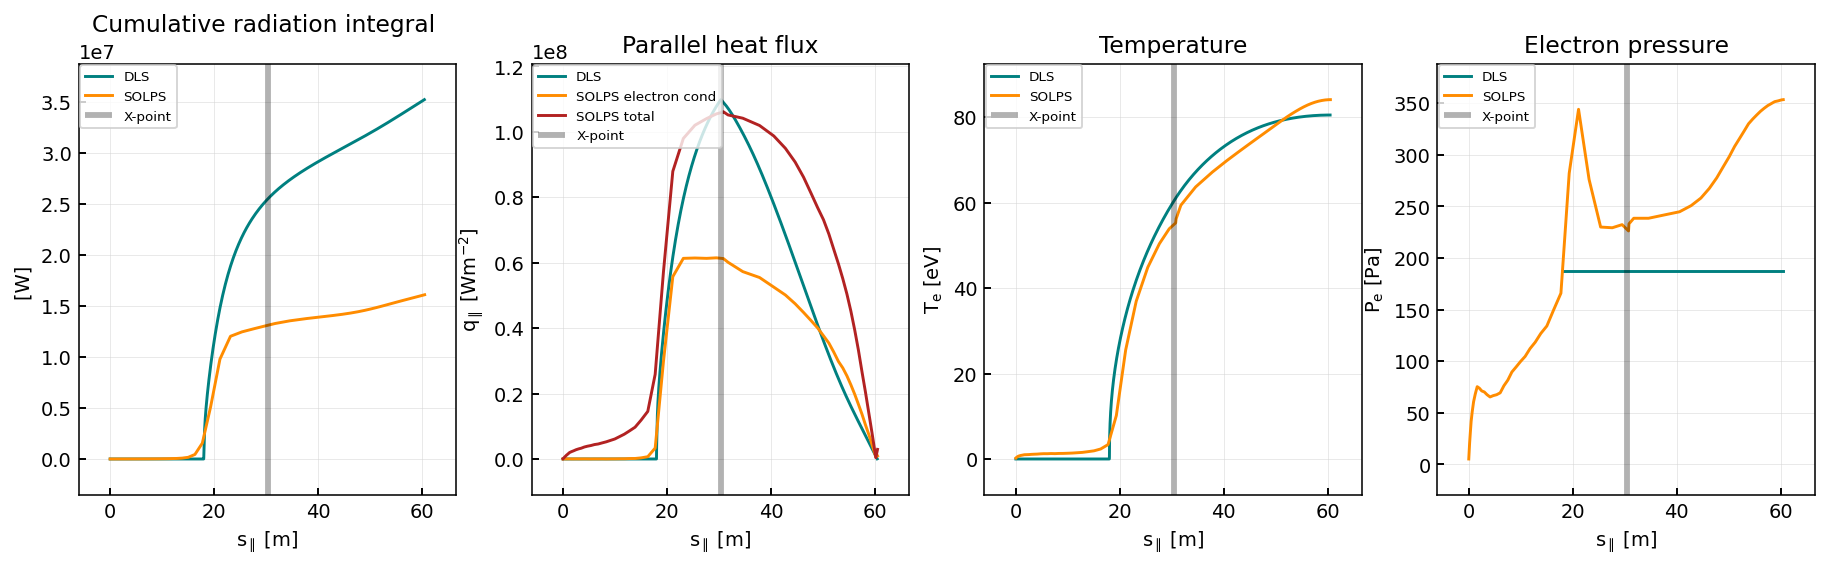

In [185]:
case = "SPR45"
sepadd = 9
slc = store_slc[case]

d = eqb[case]["ol"][sepadd]

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    # "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "Lfunc": lambda x: LfuncSPR45(1, x),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Original average Cz and qpar
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 

# Tune peak qpar
constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 0.115e9  # Total heat flux
# constants_default["qpllu0"] = 0.067e9  # Total heat flux


# Correct cooling curve, peak qpar
# constants_default["qpllu0"] = 0.15e9  # Total heat flux

# Correct cooling curve, lower kappa, peak qpar
constants_default["qpllu0"] = 0.15e9  # Total heat flux
constants_default["kappa0"] = 2000

SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [18],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGrid = True)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])

comp = compare_SOLPS_DLS(slc, out, region = "outer_lower", sepadd = sepadd)
comp.plot(["Cumrad", "qpar", "Te", "Pe"], normalise_radiation = False)



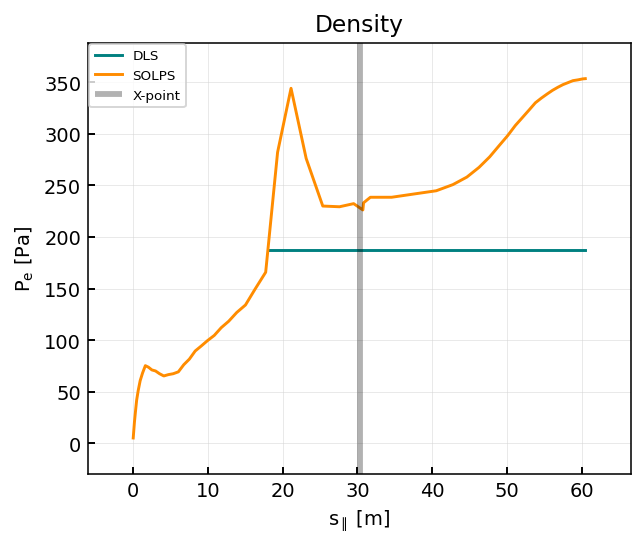

In [181]:
fig, ax = plt.subplots()
comp.plot_Pe(ax = ax)

## qpar/sepadd analysis
- Choose SOL ring

### Target heat flux profile

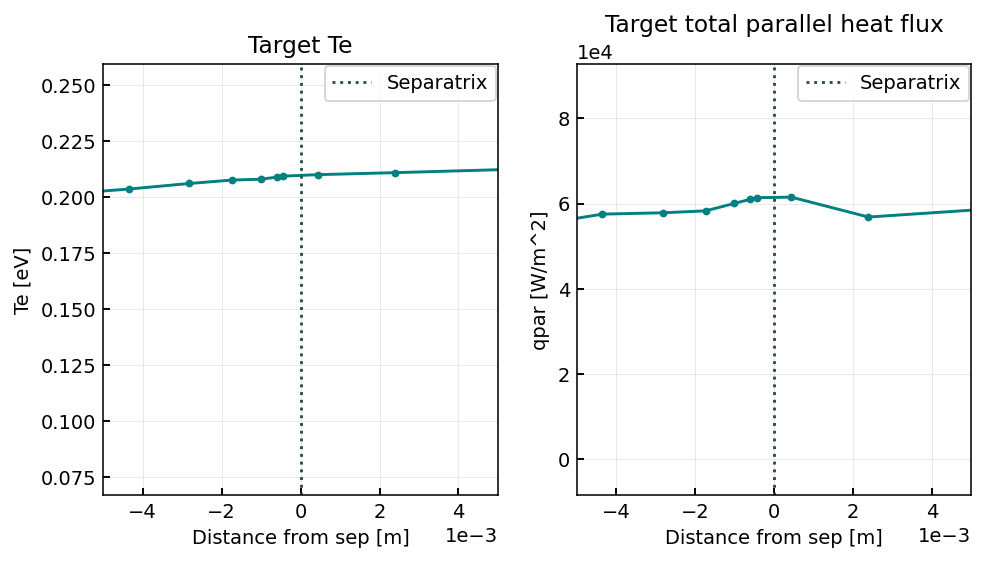

In [289]:
slc = store_slc["SPR45"]

df = slc.get_1d_radial_data(["fhex_total", "fhix_total", "Te", "hy"], region = "outer_lower_target")
df["fhtotal"] = (df["fhex_total"] + df["fhix_total"])

fig, axes = plt.subplots(1,2, figsize = (8,4))
ax = axes[0]
ax.plot(df["dist"], df["Te"], marker = "o", ms = 3)
ax.set_ylabel("Te [eV]")
ax.set_title("Target Te")


ax = axes[1]
ax.plot(df["dist"], df["fhtotal"] / df["apar"], marker = "o", ms = 3)
ax.set_title("Target total parallel heat flux")
ax.set_ylabel("qpar [W/m^2]")

sepadd = 3

for ax in axes:
    
    sepind = slc.g["sep"]
    
    ylims = ax.get_ylim()
    ax.vlines(0, ylims[0], ylims[1], ls = ":", colors = "darkslategrey", label = "Separatrix")
    # ax.vlines(df["dist"].iloc[sepind+sepadd], *ylims, ls = ":", colors = "deeppink", label = f"sepadd = {sepadd}")
    
    # ax.vlines(df["dist"].iloc[sepind], *ylims, ls = ":", label = f"sepind")
    # ax.vlines(df["dist"].iloc[sepind-1], *ylims, ls = ":", label = f"sepind - 1")
    
    ax.set_ylim(ylims)
    ax.legend()
    ax.set_xlabel("Distance from sep [m]")
    ax.set_xlim(-0.005, 0.005)

### Try to fix separatrix = 0 point...

In [295]:
df["dist2"] = df["hy"].cumsum()
df["distR"] = df["R"] - df["R"].iloc[0]

sepind = slc.g["sep"]
sepdist = df["dist2"].iloc[sepind-1] + (df["dist2"].iloc[sepind] - df["dist2"].iloc[sepind-1]) / 2
sepdistR = df["distR"].iloc[sepind-1] + (df["distR"].iloc[sepind] - df["distR"].iloc[sepind-1]) / 2
df["dist2"] -= sepdist
df["distR"] -= sepdistR

df

dist         R         Z      apar   fhex_total   fhix_total  \
0  -0.048991  5.740974 -8.544402  0.000233     0.003874     0.000130   
1  -0.040428  5.745203 -8.543510  0.023064   315.563631   252.048245   
2  -0.032937  5.753039 -8.541856  0.020304   350.105011   283.467569   
3  -0.026453  5.759858 -8.540414  0.017711   365.721649   299.372340   
4  -0.020892  5.765738 -8.539168  0.015270   350.889033   289.314854   
5  -0.016169  5.770761 -8.538102  0.013025   312.885330   256.777459   
6  -0.012227  5.774997 -8.537202  0.010958   287.309611   238.109601   
7  -0.008996  5.778497 -8.536455  0.009031   253.167054   210.018620   
8  -0.006389  5.781350 -8.535846  0.007289   217.229078   180.024983   
9  -0.004349  5.783622 -8.535359  0.005772   180.889888   151.239754   
10 -0.002824  5.785366 -8.534982  0.004359   137.974722   114.232622   
11 -0.001732  5.786648 -8.534702  0.003163   101.658213    82.783411   
12 -0.001012  5.787533 -8.534506  0.002132    70.837663    57.182151   
13 -0.000600  5.788085 -8.534380  0.001280    43.426815    34.729210   
14 -0.000438  5.788363 -8.534311  0.000607    20.695517    16.543813   
15  0.000438  5.788870 -8.534204  0.002273    77.253748    62.582026   
16  0.002392  5.790255 -8.533923  0.005275   149.120591   150.800945   
17  0.005642  5.792801 -8.533400  0.008844   256.171343   264.395708   
18  0.010370  5.796712 -8.532591  0.012987   414.706566   412.869576   
19  0.016759  5.802153 -8.531460  0.017709   651.677564   595.416694   
20  0.025019  5.809317 -8.529969  0.023011   895.289664   801.268635   
21  0.035306  5.818384 -8.528081  0.028898  1268.047121  1137.272030   
22  0.047764  5.829490 -8.525766  0.035372  1584.560190  1396.339788   
23  0.062468  5.842779 -8.522991  0.042288  1877.210456  1631.065587   
24  0.079563  5.858370 -8.519733  0.049880  1943.240248  1667.948881   
25  0.099109  5.876338 -8.515974  0.058052  1876.810720  1604.607768   
26  0.121147  5.896709 -8.511709  0.066802  1537.397199  1308.844020   
27  0.145671  5.919517 -8.506930  0.076127  1041.435212   875.115834   
28  0.172653  5.944762 -8.501635  0.086083   701.589958   572.885416   
29  0.202006  5.972368 -8.495840  0.096552   423.975195   327.086433   
30  0.233589  6.002237 -8.489564  0.107576   220.540161   157.043442   
31  0.267318  6.034235 -8.482834  0.119394   130.942425    86.279633   
32  0.302965  6.068177 -8.475689  0.131630    58.851164    34.910002   
33  0.303314  6.085783 -8.471981  0.001316    -0.002424     0.000027   

          Te        hy      fhtotal     dist2     distR  
0   0.197165  0.000087     0.004004 -0.048991 -0.047642  
1   0.202227  0.008563   567.611876 -0.040428 -0.043413  
2   0.205675  0.007491   633.572580 -0.032937 -0.035578  
3   0.214243  0.006485   665.093989 -0.026453 -0.028759  
4   0.210774  0.005561   640.203887 -0.020892 -0.022878  
5   0.203686  0.004722   569.662788 -0.016169 -0.017856  
6   0.207673  0.003943   525.419212 -0.012227 -0.013620  
7   0.205195  0.003231   463.185674 -0.008996 -0.010120  
8   0.200873  0.002607   397.254061 -0.006389 -0.007267  
9   0.203596  0.002040   332.129641 -0.004349 -0.004994  
10  0.206074  0.001525   252.207344 -0.002824 -0.003250  
11  0.207618  0.001092   184.441623 -0.001732 -0.001968  
12  0.207974  0.000720   128.019814 -0.001012 -0.001083  
13  0.208905  0.000412    78.156024 -0.000600 -0.000531  
14  0.209366  0.000162    37.239330 -0.000438 -0.000253  
15  0.210025  0.000877   139.835774  0.000438  0.000253  
16  0.210917  0.001953   299.921536  0.002392  0.001638  
17  0.212551  0.003251   520.567051  0.005642  0.004184  
18  0.221914  0.004727   827.576142  0.010370  0.008095  
19  0.230844  0.006389  1247.094257  0.016759  0.013537  
20  0.243321  0.008260  1696.558299  0.025019  0.020700  
21  0.239124  0.010288  2405.319151  0.035306  0.029767  
22  0.225471  0.012458  2980.899978  0.047764  0.040874  
23  0.217692  0.014703  3508.276043  0.062468  0.054162  
24  0.213927  0.017096  3611.189129  

In [209]:
df[df["dist"] == 0].index

Index([15], dtype='int64')

### qpar along field line at different sepadd
- First SOL ring has highest heat flux

C:\Users\mikek\AppData\Local\Temp\ipykernel_28892\4042264631.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]


Text(0.5, 1.0, 'Parallel profiles of q_par \n Solid = conductive electron heat flux \n dots = total heat flux')

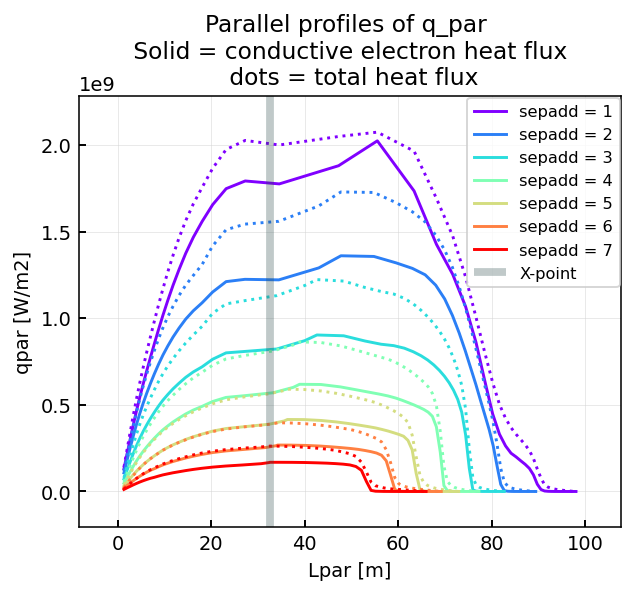

In [241]:
fig, ax = plt.subplots()

num_rings = 7

colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]

for i in range(num_rings):
    df = store_slc["SPR45"].get_1d_poloidal_data(["hx", "vol", "fhex_cond", "fhx_total"], sepadd = i+1)   
    # df["da"] = df[
    df["fhex_cond"] /= (df["vol"] / df["Spar"].diff())
    df["fhx_total"] /= (df["vol"] / df["Spar"].diff())
    ax.plot(df["Spar"], df["fhex_cond"], label = f"sepadd = {i+1}", color = colors[i]) 
    ax.plot(df["Spar"], df["fhx_total"], ls = ":",  color = colors[i]) 
    
ylims = ax.get_ylim()
ax.vlines(df[df["Xpoint"]==1]["Spar"], ylims[0], ylims[1], ls = "-", colors = "darkslategrey", lw = 4, alpha = 0.3, label = "X-point")
ax.set_ylim(ylims)
    
ax.legend(fontsize = "small")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("qpar [W/m2]")
ax.set_title("Parallel profiles of q_par \n Solid = conductive electron heat flux \n dots = total heat flux")
# ax.set_yscale("log")


### Front widths

C:\Users\mikek\AppData\Local\Temp\ipykernel_28892\2035602845.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]


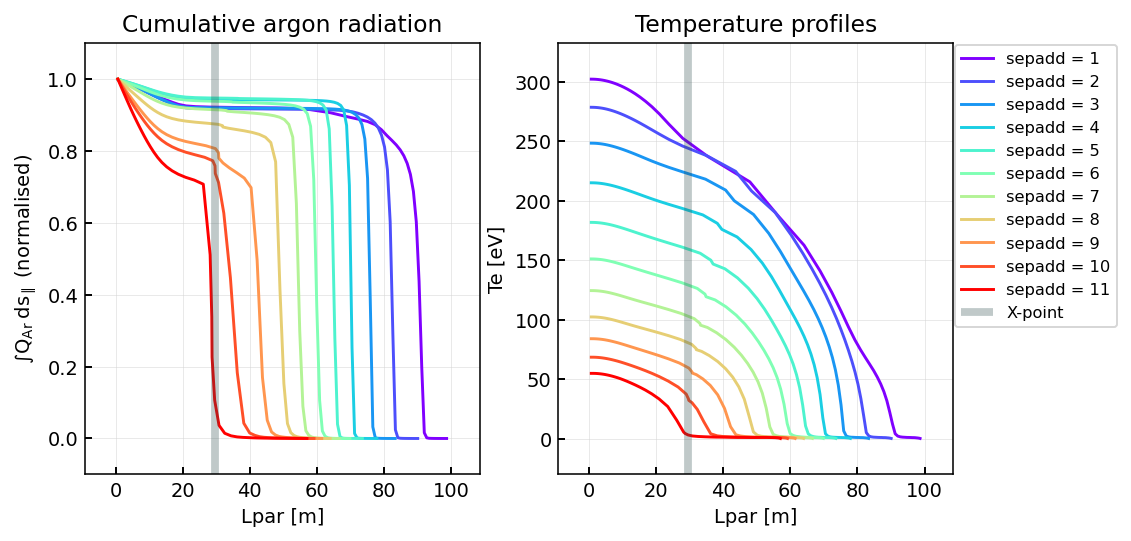

In [487]:
fig, axes = plt.subplots(1,2, figsize = (8,4))

num_rings = 11

colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]

for i in range(num_rings):
    df = store_slc["SPR45"].get_1d_poloidal_data(["RAr", "Te"], sepadd = i+1)   
    cumR = df["RAr"][::-1].cumsum()[::-1]
    cumR /= cumR[0]
    axes[0].plot(df["Spar"], cumR, color = colors[i]) 
    axes[1].plot(df["Spar"], df["Te"], label = f"sepadd = {i+1}", color = colors[i]) 
    

for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(df[df["Xpoint"]==1]["Spar"], ylims[0], ylims[1], ls = "-", colors = "darkslategrey", lw = 4, alpha = 0.3, label = "X-point")
    ax.set_ylim(ylims)
    
    
    ax.set_xlabel("Lpar [m]")

axes[0].set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")
axes[0].set_title("Cumulative argon radiation")
axes[1].set_ylabel("Te [eV]")
axes[1].set_title("Temperature profiles")
axes[1].legend(fontsize = "small", bbox_to_anchor = (1,1), loc = "upper left")
# ax.set_yscale("log")


- Conduction is about 75% - 80% of total heat flux

Text(0.5, 0.98, 'Breakdown at sepadd = 3')

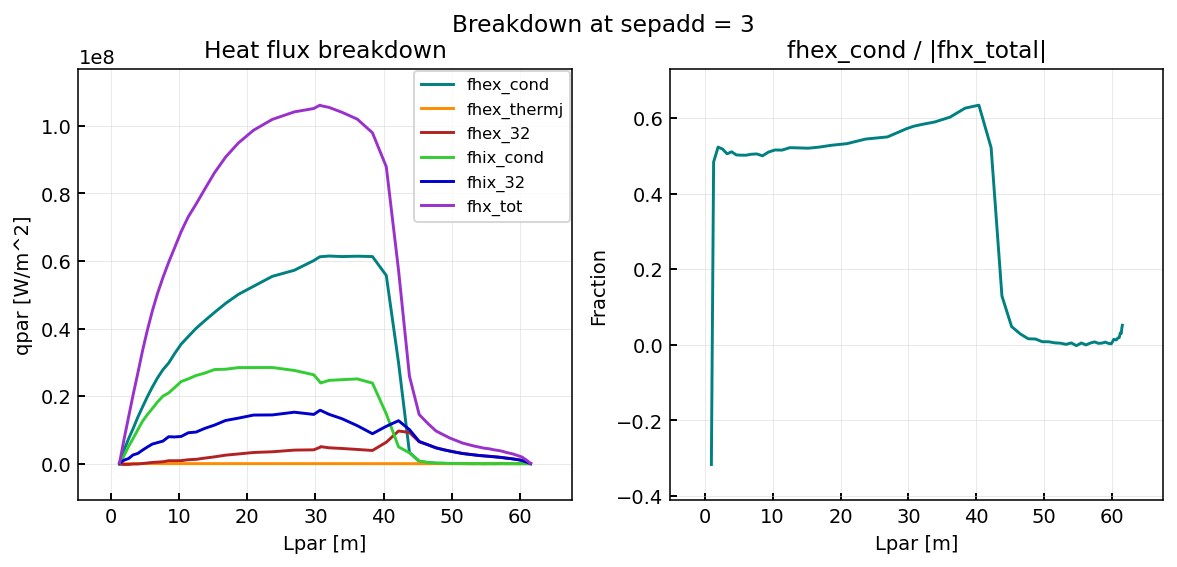

In [177]:
params = ["fhex_cond", "fhex_thermj", "fhex_32", "fhix_cond", "fhix_32"]
df = store_slc["SPR45"].get_1d_poloidal_data(params + ["vol"], sepadd = 9)  
df["apar"] = (df["vol"] / df["Spar"].diff())

df["fhex_32"] *= 5/3
df["fhix_32"] *= 5/3

df["fhx_tot"] = df["fhex_cond"] + df["fhex_thermj"] + df["fhex_32"] + df["fhix_cond"] + df["fhix_32"]
df["fhx_abstot"] = np.abs(df["fhex_cond"]) + np.abs(df["fhex_thermj"]) + np.abs(df["fhex_32"]) + np.abs(df["fhix_cond"]) + np.abs(df["fhix_32"])

fig, axes = plt.subplots(1,2, figsize = (10,4))

for param in params:
    axes[0].plot(df["Spar"], df[param]/df["apar"], label = param) 
    
axes[0].plot(df["Spar"], df["fhx_tot"]/df["apar"], label = "fhx_tot")
# ax.plot(df["Spar"], df["fhex_thermj"], label = "fhex_cond") 

axes[1].plot(df["Spar"], df["fhex_cond"]/df["fhx_abstot"])

axes[0].legend(fontsize = "small", loc = "upper right")
axes[0].set_title("Heat flux breakdown")
axes[1].set_title("fhex_cond / |fhx_total|")
axes[0].set_ylabel("qpar [W/m^2]")
axes[1].set_ylabel("Fraction")
for ax in axes:
    ax.set_xlabel("Lpar [m]")
    
fig.suptitle("Breakdown at sepadd = 3")

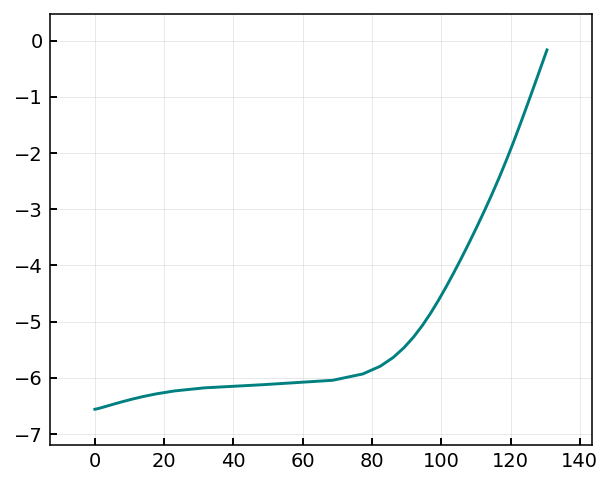

In [31]:
df = slc.get_1d_poloidal_data(["R", "Z", "Btot"], sepadd = 1, region = "inner_lower").iloc[::-1]

fig, ax =plt.subplots()
ax.plot(df["Spar"], df["Z"], label = "DLS")
# ax.set_aspect("equal")

In [ ]:
df = slc.get_1d_poloidal_data(["R", "Z", "Btot"], sepadd = 1, region = "inner_lower")
df["Spol"] = df["Spol"][::-1].values
df["Spar"] = df["Spar"][::-1].values

df

# Inner divertor SOL ring analysis

C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\964101488.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]


Text(0.5, 1.0, 'Parallel profiles of q_par \n Solid = conductive electron heat flux \n dots = total heat flux')

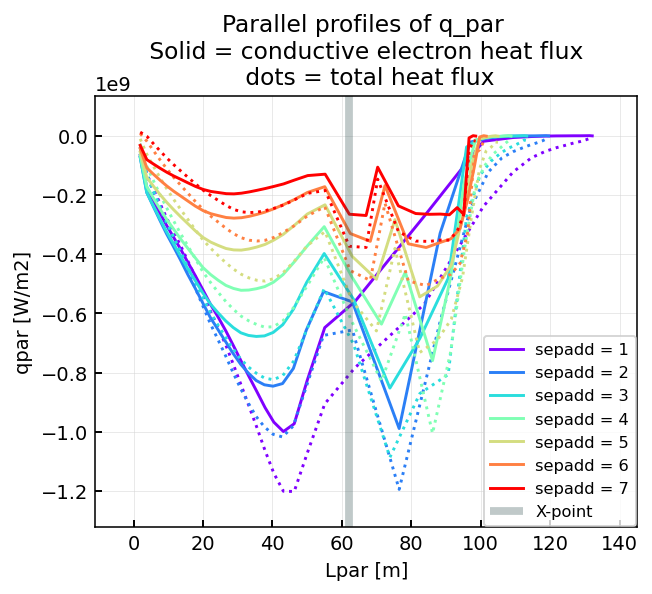

In [190]:
fig, ax = plt.subplots()

num_rings = 7

colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]

for i in range(num_rings):
    df = store_slc["SPR45"].get_1d_poloidal_data(["hx", "vol", "fhex_cond", "fhx_total"], region = "inner_lower", sepadd = i+1)   
    # df["da"] = df[
    df["fhex_cond"] /= (df["vol"] / df["Spar"].diff())
    df["fhx_total"] /= (df["vol"] / df["Spar"].diff())
    ax.plot(df["Spar"], df["fhex_cond"], label = f"sepadd = {i+1}", color = colors[i]) 
    ax.plot(df["Spar"], df["fhx_total"], ls = ":",  color = colors[i]) 
    
ylims = ax.get_ylim()
ax.vlines(df[df["Xpoint"]==1]["Spar"], ylims[0], ylims[1], ls = "-", colors = "darkslategrey", lw = 4, alpha = 0.3, label = "X-point")
ax.set_ylim(ylims)
    
ax.legend(fontsize = "small")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("qpar [W/m2]")
ax.set_title("Parallel profiles of q_par \n Solid = conductive electron heat flux \n dots = total heat flux")
# ax.set_yscale("log")


C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\829945346.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]


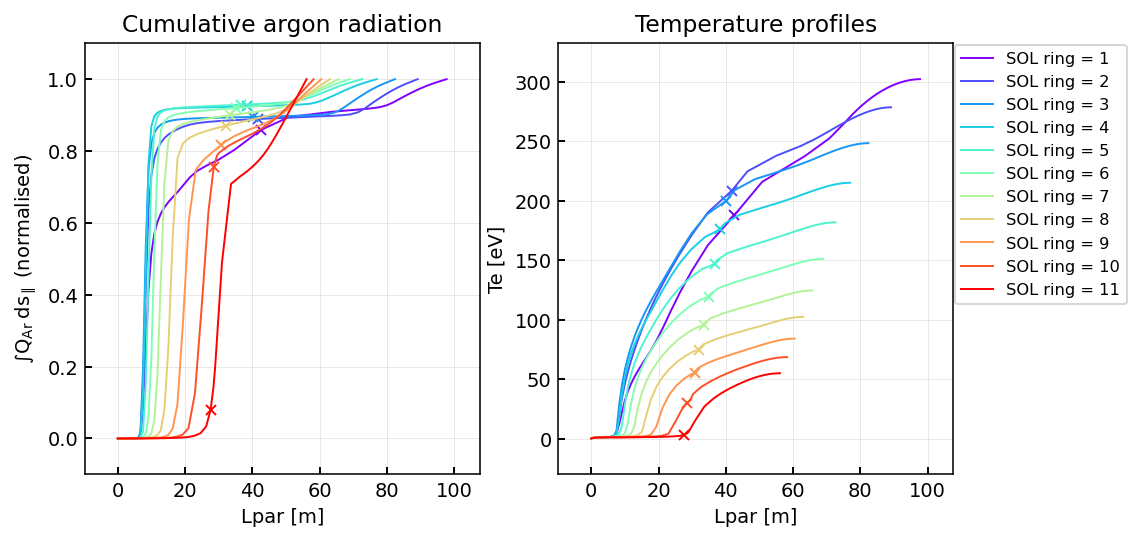

In [219]:
fig, axes = plt.subplots(1,2, figsize = (8,4))

num_rings = 11

colors = [plt.cm.get_cmap("rainbow", num_rings)(x) for x in range(num_rings)]

for i in range(num_rings):
    df = store_slc["SPR45"].get_1d_poloidal_data(["RAr", "Te", "Btot", "R"], sepadd = i+1, target_first = True)   
    cumR = sp.integrate.cumulative_trapezoid(y = df["RAr"] / df["Btot"], x = df["Spar"], initial = 0)
    # cumR = cumR[::-1]
    df["cumR"] = cumR/cumR[-1]
    dfx = df[df["Xpoint"]==1]

    axes[0].plot(df["Spar"], df["cumR"], color = colors[i], lw = 1, marker = "o", ms = 0) 
    axes[0].plot(dfx["Spar"], dfx["cumR"], color = colors[i], marker = "x", ms = 5) 
    
    axes[1].plot(df["Spar"], df["Te"], label = f"SOL ring = {i+1}", color = colors[i], lw = 1, marker = "o", ms = 0) 
    axes[1].plot(dfx["Spar"], dfx["Te"], color = colors[i], marker = "x", ms = 5) 

for ax in axes:
    ylims = ax.get_ylim()
    # ax.vlines(df[df["Xpoint"]==1]["Spar"], ylims[0], ylims[1], ls = "-", colors = "darkslategrey", lw = 4, alpha = 0.3, label = "X-point")
    ax.set_ylim(ylims)
    
    
    ax.set_xlabel("Lpar [m]")

axes[0].set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")
axes[0].set_title("Cumulative argon radiation")
axes[1].set_ylabel("Te [eV]")
axes[1].set_title("Temperature profiles")
axes[1].legend(fontsize = "small", bbox_to_anchor = (1,1), loc = "upper left")
# ax.set_yscale("log")


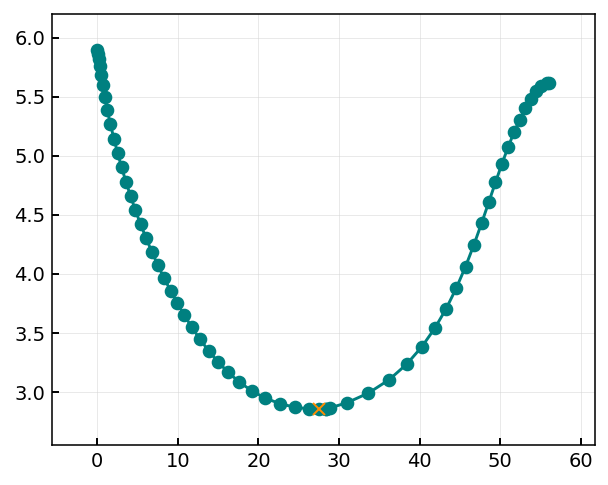

In [214]:
fig, ax = plt.subplots()
ax.plot(df["Spar"], df["R"], marker = "o")
ax.plot(dfx["Spar"], dfx["R"], marker = "x", lw = 0)

# Run DLS for SPR45 inner, sepadd = 1


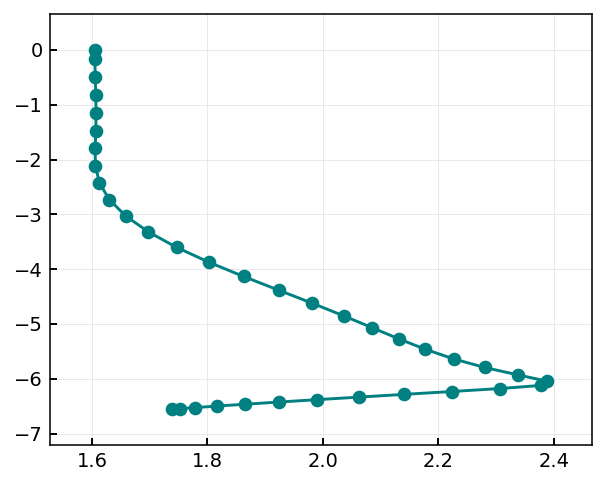

In [230]:
fig, ax = plt.subplots()
ax.plot(sp["R"], sp["Z"], marker = "o")

Solving...30.00...Complete in 1.7 seconds
[4.385426084771217e+19]


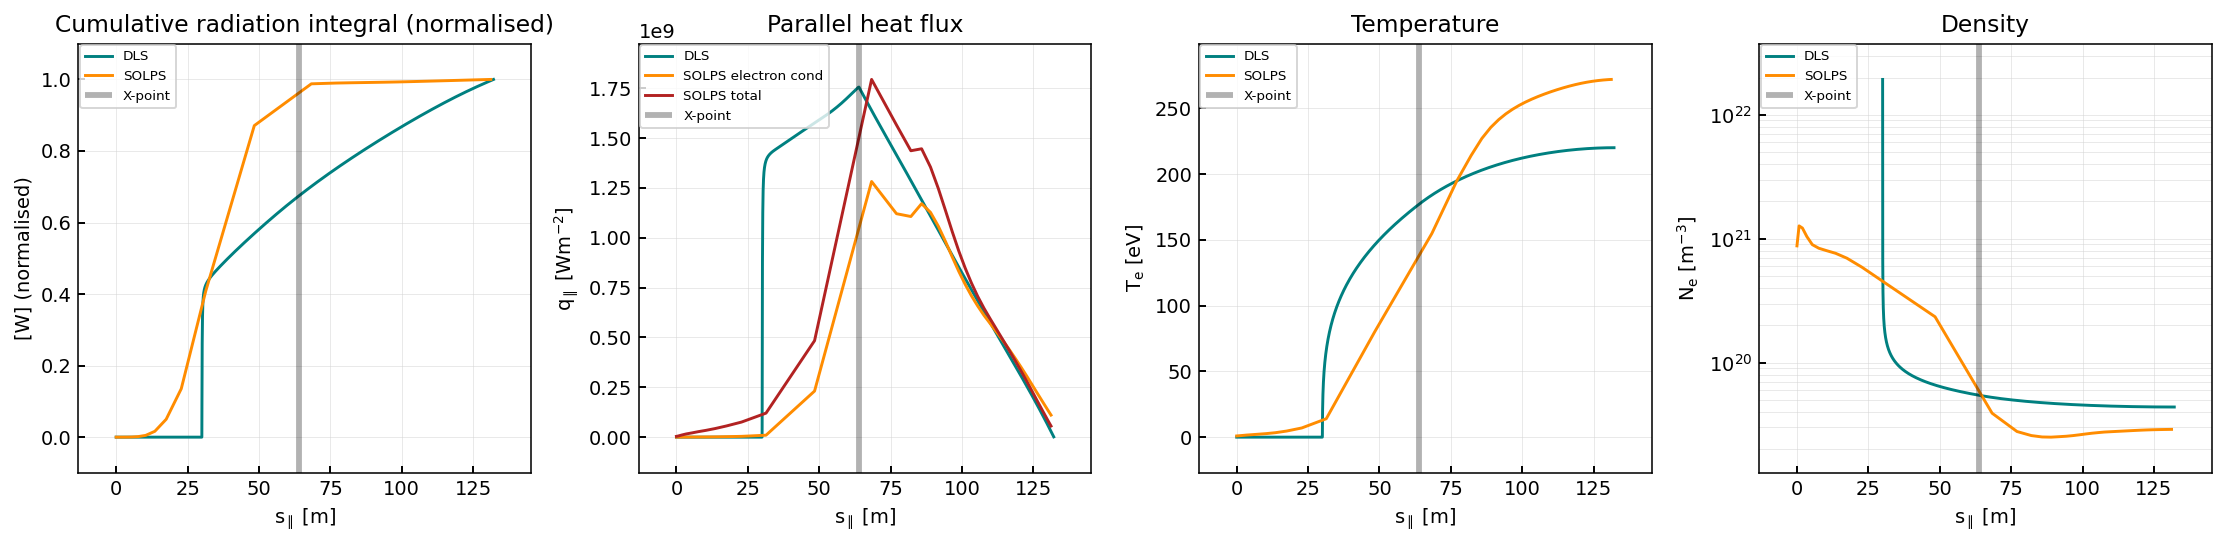

In [376]:
case = "SPR45"
sepadd = 1
slc = store_slc[case]

# d = eqb[case]["il"][sepadd]
d = eqb_alt[case]["il"][sepadd]

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Tune qpar
# constants_default["qpllu0"] = 2.6e9

# Tune qpar, cz
constants_default["qpllu0"] = 2.6e9
constants_default["cz0"] = 0.15

# Tune qpar to same Tu
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 * 1.6

# Correct average Cz and tune qpar to same radiation
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 4e8

# Tune qpar to same q as solps
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 * 0.1


SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [30],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGridRefinementRatio = 5,
            dynamicGridRefinementWidth = 2,
            dynamicGridResolution = 1000,
            dynamicGrid = True)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])

comp = compare_SOLPS_DLS(slc, out, region = "inner_lower", sepadd = sepadd)
comp.plot(["Cumrad", "qpar", "Te", "Ne"], normalise_radiation = True)


# fig, ax =plt.subplots()
# ax.plot(out["Sprofiles"][0], out["Rprofiles"][0], marker = "o", ms = 3, lw = 1)
# ax.set_xlim(27,32)


## Higher sepadd

Solving...2.00...Complete in 1.2 seconds
[2.8045576676425347e+19]


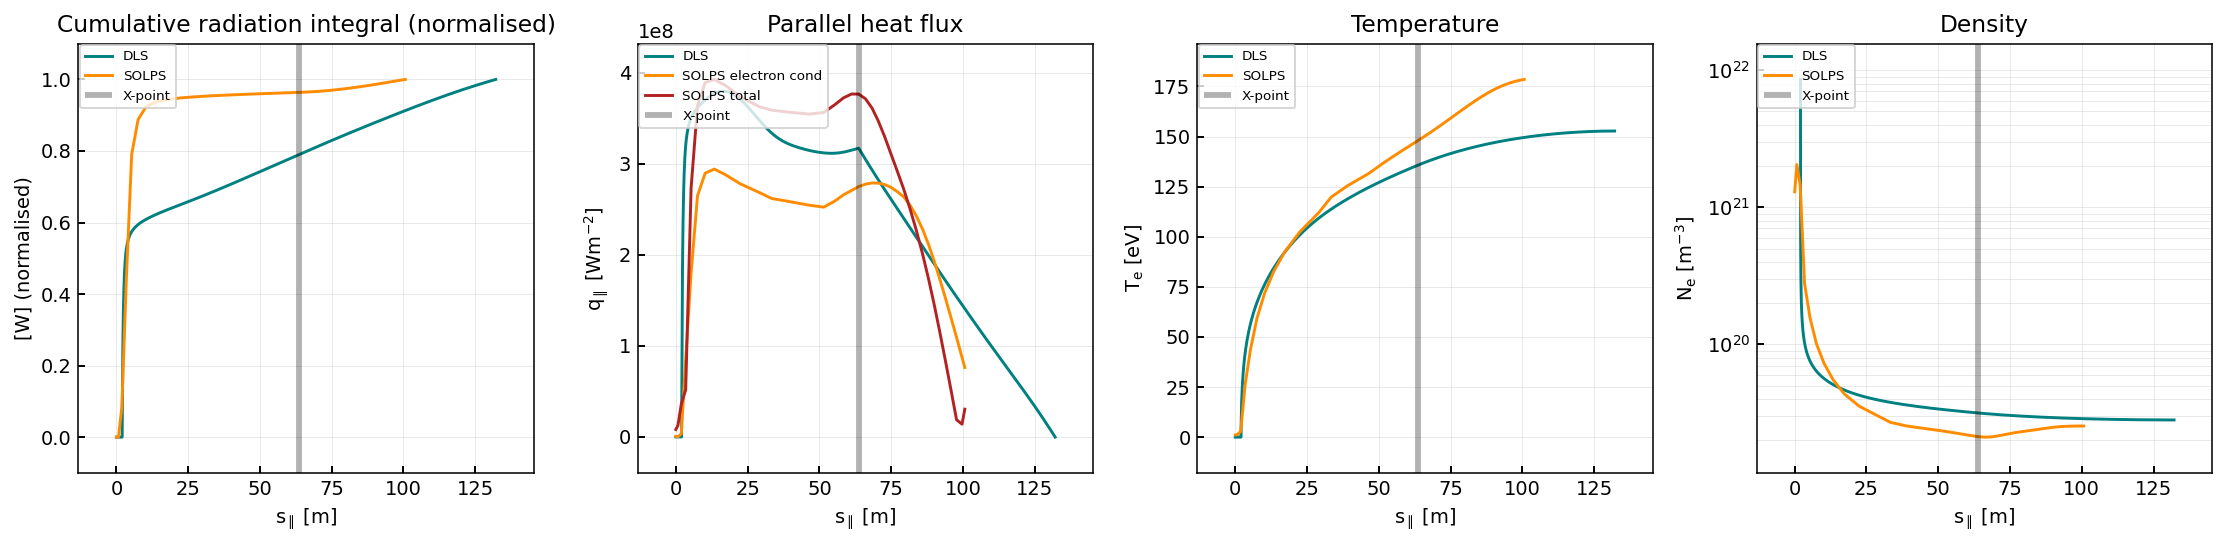

In [380]:
case = "SPR45"
sepadd = 6
slc = store_slc[case]

# d = eqb[case]["il"][sepadd]
d = eqb_alt[case]["il"][sepadd]

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Tune qpar
constants_default["qpllu0"] = 0.4e9

# Tune qpar, cz
# constants_default["qpllu0"] = 2.6e9
# constants_default["cz0"] = 0.15



SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [2],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGridRefinementRatio = 5,
            dynamicGridRefinementWidth = 2,
            dynamicGridResolution = 1000,
            dynamicGrid = True)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])

comp = compare_SOLPS_DLS(slc, out, region = "inner_lower", sepadd = sepadd)
comp.plot(["Cumrad", "qpar", "Te", "Ne"], normalise_radiation = True)


# fig, ax =plt.subplots()
# ax.plot(out["Sprofiles"][0], out["Rprofiles"][0], marker = "o", ms = 3, lw = 1)
# ax.set_xlim(27,32)


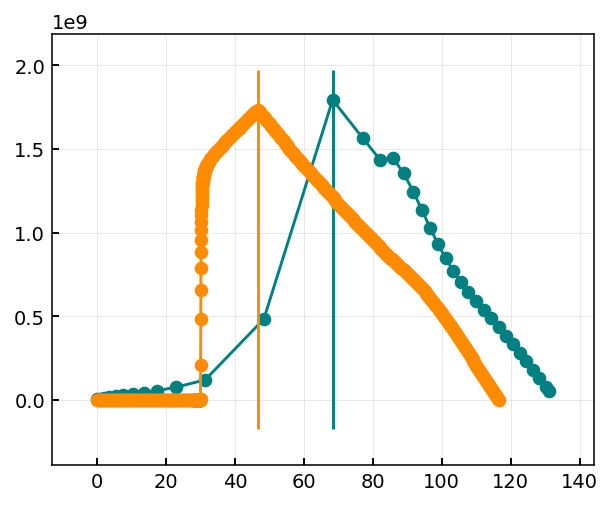

In [151]:
df = comp.solps
dls = comp.dls
dfx = df[df["Xpoint"]==1]
dlsx = dls[dls["Xpoint"]==1]

fig, ax = plt.subplots()

ax.plot(df["Spar"], df["fhx_total"]*-1, marker = "o")
ylim = ax.get_ylim()
ax.vlines(dfx["Spar"], *ylim)

ax.plot(dls["Spar"], dls["qpar"], marker = "o", c = "darkorange")
ax.vlines(dlsx[dlsx["Xpoint"]==1]["Spar"], *ylim, colors = "darkorange")

# ax.set_ylim(*ylim)

## Last sepadd

Solving...3.00...Complete in 0.7 seconds
[1.8634504463136117e+19]


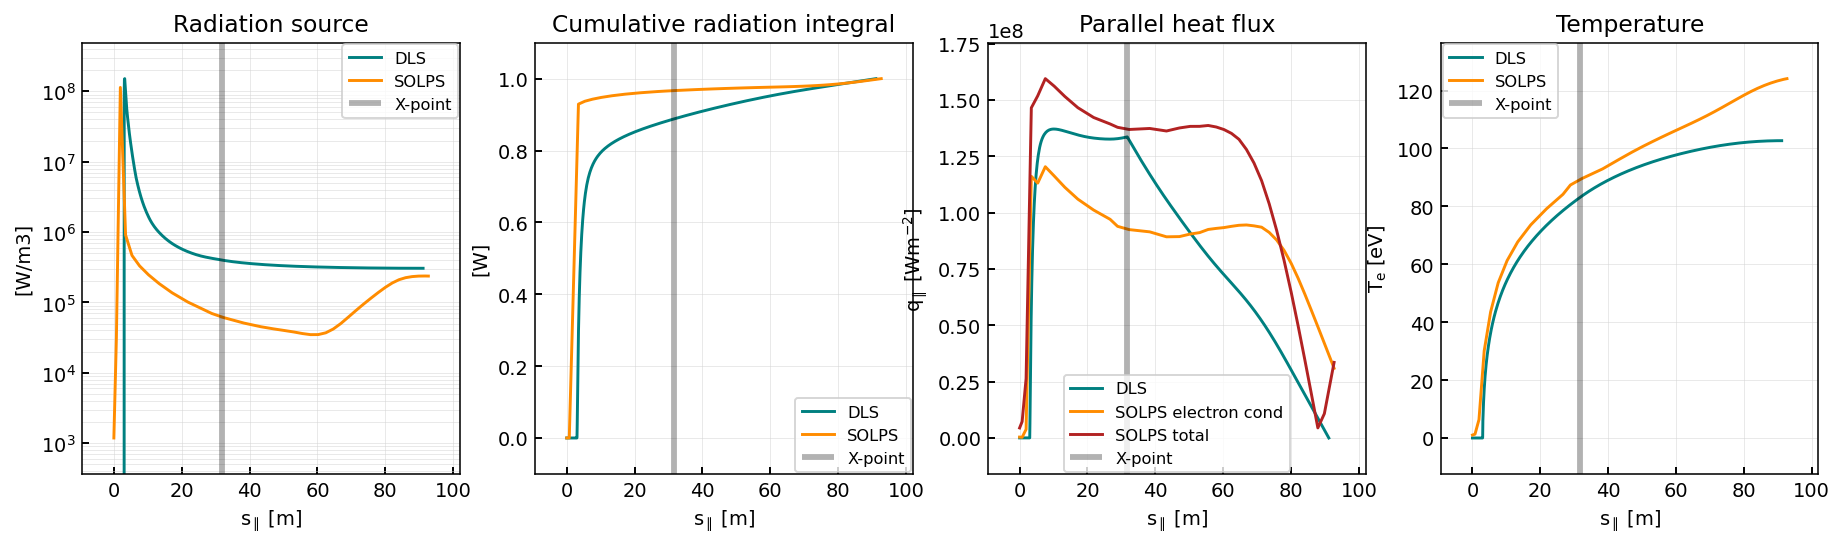

In [119]:
case = "SPR45"
sepadd = 9
slc = store_slc[case]

d = eqb[case]["il"][sepadd]

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Correct average Cz and qpar
constants_default["cz0"] = 0.045
constants_default["qpllu0"] = 0.15e9

# Tune qpar to same Tu
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 * 1.6

# Correct average Cz and tune qpar to same radiation
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 4e8

# Tune qpar to same q as solps
# constants_default["cz0"] = 0.045
# constants_default["qpllu0"] = 3.325e9 * 0.1


SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [3],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGrid = True)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])

comp = compare_SOLPS_DLS(slc, out, region = "inner_lower", sepadd = sepadd)
comp.plot(mode = "extended")


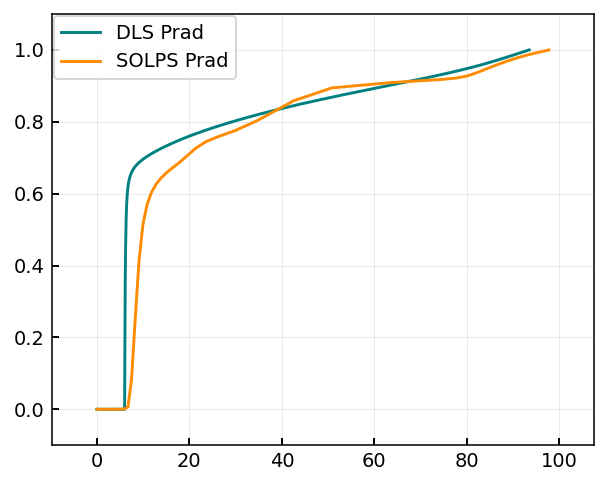

In [ ]:
fig, ax = plt.subplots()


ax.plot(dls["Spar"], dls["Prad_cum_norm"], label = "DLS Prad")
ax.plot(solps["Spar"], solps["Prad_cum_norm"], label = "SOLPS Prad")

# ax.plot(dls["Spar"], dls["Prad_per_area_cum_norm"], label = "DLS Prad")
# ax.plot(solps["Spar"], solps["Prad_per_area_cum_norm"], label = "SOLPS Prad")


# ax.set_yscale("log")
ax.legend()

In [255]:
df = slc.get_1d_poloidal_data(["hx", "vol", "R", "Te", "RAr", "ne", "fhex_cond", "fhx_total"], 
                                  sepadd = 1, region = "inner_lower", target_first = True)
df
# fig, ax = plt.subplots()
# ax.plot(df["R"], df["Z"])

ValueError: zero-size array to reduction operation minimum which has no identity

In [287]:
self = store_slc["SPR45"]
params = ["Btot", "Bpol", "Te"]
target_first = True
sepadd = 1
region = "inner_lower"

if type(params) == str:
    params = [params]

yind = self.g["sep"] + sepadd   # Ring index
omp = self.g["omp"]
imp = self.g["imp"]

if region == "outer_lower":
    selector = (slice(omp, -1), yind)
elif region == "inner_lower":
    selector = (slice(1, imp+1), yind)
else:
    raise Exception("Unrecognised region")

hx = self.bal["hx"][selector]
Btot = self.g["Btot"][selector]
Bpol = self.g["Bpol"][selector]
R = self.g["R"][selector]
Z = self.g["Z"][selector]
vol = self.g["vol"][selector]

data = {}

for param in params:
    # Look in bal or geometry
    if param in self.bal:
        data[param] = self.bal[param]
    elif param in self.g:
        data[param] = self.g[param]
    else:
        raise ValueError(f"Parameter {param} not found")
    
    if param.startswith("fh") and "x" not in param and "y" not in param:
        data[param] = data[param][:,:,0]   # Select poloidal
    
    # Catch special variables with more dimensions
    if len(data[param].shape) > 2:
        raise ValueError(f"Paramerer {param} has more than 2 dimensions")
    
    
df = pd.DataFrame()
df["R"] = R
df["Z"] = Z

## Poloidal connection length
df["Spol"] = np.cumsum(hx)  # Poloidal distance

# df["Spol"] -= df["Spol"].iloc[0]   # Now 0 is cell centre before midplane

for param in params:
    df[param] = data[param][selector]

## Parallel connection length
dSpar = hx * abs(Btot / abs(Bpol))
df["Spar"] = np.cumsum(dSpar)
df["apar"] = vol / dSpar

## X-point
if "inner" in region:
    idxmin = np.argmin(abs(R - R.max()))
elif "outer" in region:
    idxmin = np.argmin(abs(R - R.min()))
else:
    raise ValueError("Region not recognised")

df["Xpoint"] = 0
df.loc[idxmin, "Xpoint"] = 1

if "inner" in region:
    df["Spol"] = df["Spol"].iloc[-1] - df["Spol"]
    df["Spar"] = df["Spar"].iloc[-1] - df["Spar"]
    df = df.iloc[::-1].reset_index(drop = True)


# Interpolate onto Z = 0
for param in df.columns.drop("Z"):
    interp = scipy.interpolate.interp1d(df["Z"], df[param], kind = "linear")
    df.loc[0, param] = interp(0)
df.loc[0,"Z"] = 0  

df["Spol"] -= df["Spol"].iloc[0]   # Now 0 is at Z = 0

if target_first:
    df["Spol"] = df["Spol"].iloc[-1] - df["Spol"]
    df["Spar"] = df["Spar"].iloc[-1] - df["Spar"]



R         Z      Spol      Btot      Bpol          Te        Spar  \
0   1.604834  0.000000  7.306022  7.289105 -1.266057  271.909186  131.181541   
1   1.604834 -0.165225  7.140627  7.289105 -1.266057  271.799190  130.229310   
2   1.605447 -0.495300  6.809839  7.285484 -1.260746  271.472147  128.324854   
3   1.606339 -0.824253  6.479636  7.279645 -1.249660  271.031742  126.416705   
4   1.606888 -1.151340  6.150737  7.273996 -1.230656  270.472682  124.500769   
5   1.606441 -1.475811  5.824080  7.270844 -1.199943  269.786590  122.570013   
6   1.605227 -1.796920  5.500433  7.268839 -1.154440  268.959533  120.608928   
7   1.605784 -2.113918  5.180307  7.257461 -1.097360  267.978863  118.593278   
8   1.612745 -2.425951  4.864622  7.218179 -1.039651  266.836102  116.505480   
9   1.629900 -2.731952  4.554680  7.136257 -0.987810  265.530190  114.353582   
10  1.658410 -3.030723  4.249817  7.009468 -0.940251  264.071242  112.151155   
11  1.697725 -3.321111  3.951161  6.843857 -0.893964  262.474917  109.924707   
12  1.746440 -3.602128  3.661100  6.650067 -0.847591  260.749777  107.704108   
13  1.802384 -3.873049  3.379444  6.440847 -0.799995  258.894202  105.494285   
14  1.862543 -4.133511  3.105929  6.229572 -0.748438  256.876754  103.292180   
15  1.923416 -4.383447  2.841871  6.028112 -0.690392  254.658328  101.094311   
16  1.981877 -4.622819  2.588549  5.845101 -0.625047  252.160539   98.882449   
17  2.035997 -4.851319  2.346750  5.683877 -0.553875  249.256842   96.621272   
18  2.085488 -5.068240  2.116405  5.543237 -0.479161  245.747614   94.257473   
19  2.131798 -5.272479  1.898180  5.417184 -0.402199  241.321479   91.732909   
20  2.177723 -5.462597  1.693125  5.297792 -0.323603  235.441528   88.971042   
21  2.226462 -5.636882  1.502646  5.176774 -0.244431  227.052363   85.852661   
22  2.280310 -5.793476  1.325273  5.050048 -0.166746  214.090518   82.096092   
23  2.338998 -5.930892  1.158941  4.918111 -0.093766  194.682718   77.058584   
24  2.388388 -6.043702  0.992768  4.816370 -0.036281  154.787355   68.342688   
25  2.378059 -6.121560  0.842304  4.834908 -0.028495   80.223106   48.368207   
26  2.306677 -6.178105  0.742088  4.986165 -0.062834   13.986669   31.363885   
27  2.222956 -6.232393  0.634055  5.178373 -0.099473    6.982228   22.790979   
28  2.140862 -6.284480  0.532534  5.379525 -0.131544    4.639381   17.506035   
29  2.062458 -6.334310  0.435533  5.585670 -0.158767    3.375078   13.539135   
30  1.989360 -6.381366  0.344264  5.792246 -0.181056    2.680305   10.328155   
31  1.923096 -6.424907  0.260519  5.992960 -0.198391    2.245058    7.649026   
32  1.865108 -6.464122  0.185397  6.179927 -0.210955    1.872687    5.379748   
33  1.816617 -6.498057  0.120101  6.345170 -0.219499    1.584451    3.466908   
34  1.778678 -6.525587  0.066345  6.480645 -0.224868    1.267244    1.912967   
35  1.752260 -6.545409  0.025806  6.578347 -0.227979    1.051621    0.744620   
36  1.738300 -6.556144  0.000000  6.631150 -0.229551    0.920871    0.000000   

        apar  Xpoint  
0   0.000449       0  
1   0.000449       0  
2   0.000449       0  
3   0.000450       0  
4   0.000450       0  
5   0.000450       0  
6   0.000450       0  
7   0.000451       0  
8   0.000454       0  
9   0.000459       0  
10  0.000467       0  
11  0.000478       0  
12  0.000492       0  
13  0.000508       0  
14  0.000526       0  
15  0.000543       0  
16  0.000560       0  
17  0.000576       0  
18  0.000591       0  
19  0.000604       0  
20  0.000618       0  
21  0.000632       0  
22  0.000648       0  
23  0.000666       0  
24  0.000680       1  
25  0.000677       0  
26  0.000657       0  
27  0.000632       0  
28  0.000609       0  
29  0.000586       0  
30  0.000565       0  
31  0.000546       0  
32  0.000530       0  
33  0.000516       0  
34  0.000505       0  
35  0.000498       0  
36  0.000494       0

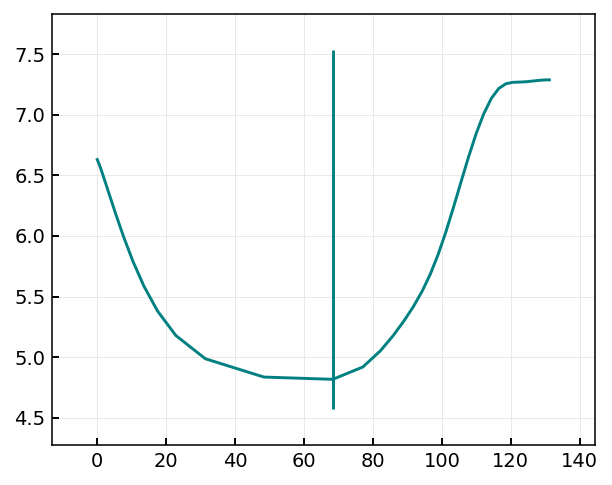

In [300]:
fig, ax = plt.subplots()
ax.plot(df["Spar"], df["Btot"])

ax.vlines(df[df["Xpoint"]==1]["Spar"], *ax.get_ylim())


In [267]:
slc.g["R"][slice(1, 37), slc.g["sep"]+1]

masked_array(data=[1.7382997 , 1.75226001, 1.77867753, 1.81661704,
                   1.86510777, 1.92309587, 1.98936042, 2.06245757,
                   2.14086169, 2.222956  , 2.30667701, 2.37805862,
                   2.38838848, 2.3389979 , 2.28030959, 2.22646239,
                   2.17772339, 2.13179781, 2.08548823, 2.03599706,
                   1.98187728, 1.92341637, 1.86254336, 1.80238405,
                   1.74644021, 1.69772505, 1.6584099 , 1.6298998 ,
                   1.61274539, 1.60578371, 1.60522707, 1.60644115,
                   1.60688796, 1.60633942, 1.60544698, 1.60483436],
             mask=False,
       fill_value=1e+20)

# Run DLS for V10

Text(0.5, 0, 'Distance from sep [m]')

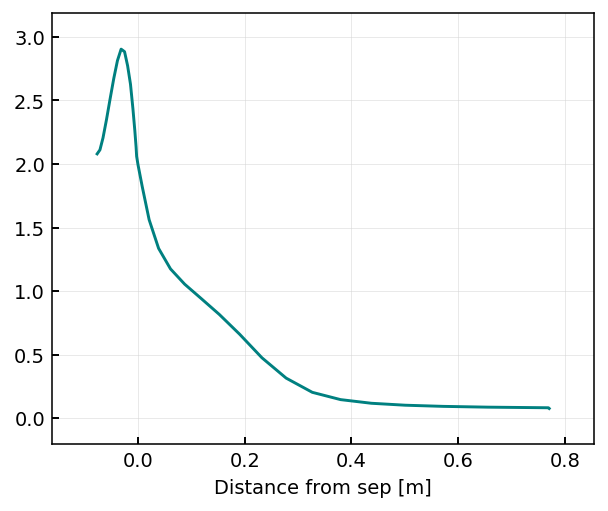

In [44]:
slc = store_slc["V10"]

df = slc.get_1d_radial_data(["fhex_total", "fhix_total", "Te"], region = "outer_lower_target")
df["fhtotal"] = df["fhex_total"] + df["fhix_total"]

fig, ax = plt.subplots()
ax.plot(df["dist"], df["Te"])

ax.set_xlabel("Distance from sep [m]")

(-6.8, -6.5)

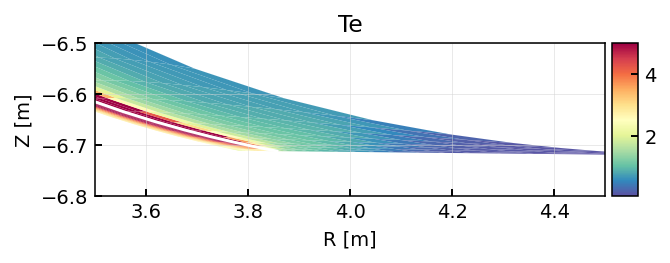

In [51]:
fig, ax = plt.subplots()
slc.plot_2d("Te", ax = ax, vmax = 5)
ax.set_xlim(3.5,4.5)
ax.set_ylim(-6.8,-6.5)

Solving...0.6000...Complete in 0.9 seconds
[1.3976542341388487e+19]


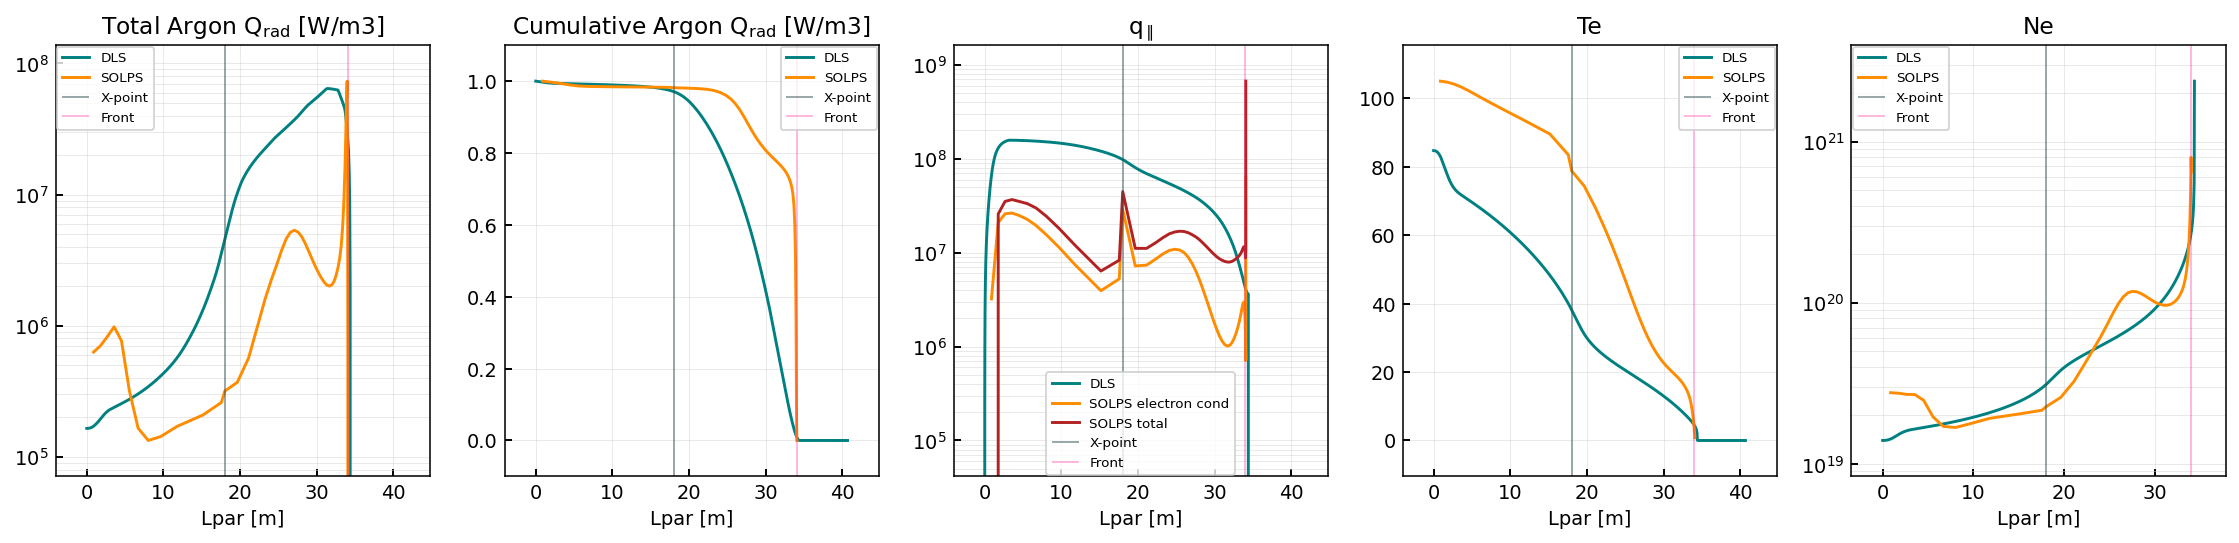

In [73]:
case = "V10"

d = eqb[case]["ol"]

# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 2.25e9 ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

# Tune density
constants_default["cz0"] = 0.05
constants_default["qpllu0"] = 3.25e9*0.05



SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 10) # 
SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

try: 
        out = run_dls(
            constants = constants_default, 
            radios = radios_default, 
            d = d,
            SparRange = [0.6],
            control_variable = "density",
            verbosity = 0,
            Ctol = 1e-3,
            Ttol = 1e-3,
            dynamicGrid = True)
    
except KeyboardInterrupt:
    print("Stopped")
    sys.exit(0)
print(out["cvar"])

compare_SOLPS_DLS(store_slc[case], out, sepadd = 2)



## Separate qpar plot

In [ ]:
df = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhe_cond", "fhe_32", "fhi_cond", "fhi_32", "fhe_thermj"], sepadd = 1)
for param in ["fhe_32", "fhi_32"]:
    df[param] = df[param] * 5/3
    
df["fhe_total"] = df["fhe_cond"] + df["fhe_32"] + df["fhe_thermj"]
df["fhi_total"] = df["fhi_cond"] + df["fhi_32"]
df["fh_total"] = df["fhe_total"] + df["fhi_total"]

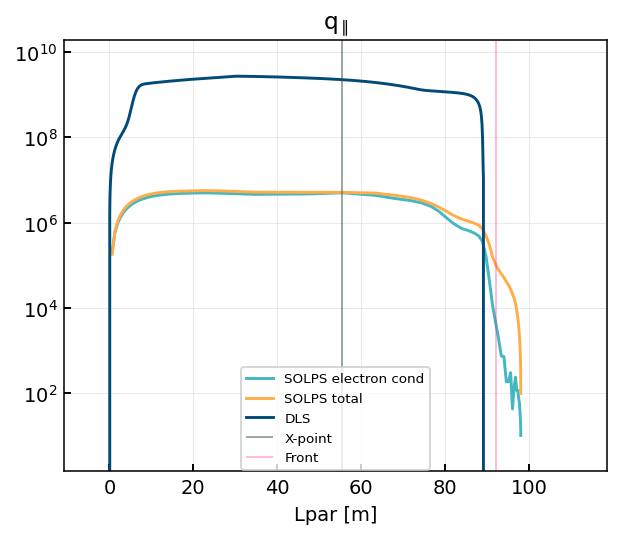

In [ ]:


fig, ax = plt.subplots()
ax.set_title("$q_{\parallel}$")
ax.plot(df["Spar"], df["fhe_cond"], label = "SOLPS electron cond")
ax.plot(df["Spar"], df["fh_total"], label = "SOLPS total")
ax.plot(dlsSpar, dlsqpar, label = "DLS")
ax.set_yscale("log")

ax.set_xlabel("Lpar [m]")
ylims = ax.get_ylim()
ax.vlines(dfx["Spar"], *ylims, color = "darkslategrey", ls = "-", alpha = 0.5, lw = 1, label = "X-point")
ax.vlines(dffront["Spar"], *ylims, color = "deeppink", ls = "-", alpha = 0.3, lw = 1, label = "Front")
ax.set_ylim(ylims)
ax.legend(fontsize = "x-small")

# Extract effective Lz curves

C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\2001939534.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('plasma', 5)


Text(0.5, 1.0, 'Cooling curves: SOLPS vs. DLS vs. ADAS')

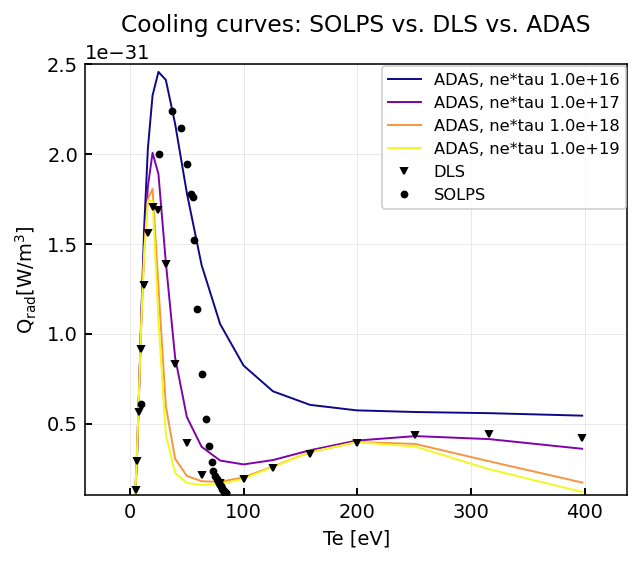

In [68]:
slc = store_slc["SPR45"]
rd2 = rd.sel(dim_electron_temp=slice(None, 500), dim_ne_tau=slice(1e16, None))

fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', 5)
colors = [cmap(x) for x in np.linspace(0,1, len(rd2["dim_ne_tau"]))]
ms = 3
marker = "X"



for i, neTau in enumerate(rd2["dim_ne_tau"]):
    data = rd2["equilibrium_Lz"].sel(dim_ne_tau = neTau, dim_electron_density=1e20, method="nearest")
    data.plot(ax = ax, label = f"ADAS, ne*tau {neTau:.1e}", color = colors[i], lw = 1)
    

radas_temp = rd2["dim_electron_temp"].values
ax.plot(radas_temp, [LfuncKallenbach("Ar")(T) for T in radas_temp], label = "DLS", c = "k", marker = "v", lw = 0, ms = ms)

solps = slc.get_1d_poloidal_data(["Te", "RAr", "fAr", "ne"], sepadd = 9)
solps["Rar"] = abs(solps["RAr"])
ax.plot(solps["Te"], solps["RAr"]/(solps["ne"]**2 * solps["fAr"]), c = "k", marker = "o", lw = 0, ms = ms, label = "SOLPS")

# ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_xlabel("Te [eV]")
ax.set_ylabel(f"$Q_{{rad}} [W/m^3]$")
ax.set_ylim(1e-32, 2.5e-31)
ax.legend(loc = "upper right", fontsize = "small")
ax.set_title("Cooling curves: SOLPS vs. DLS vs. ADAS")

C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\3361525342.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('plasma', 5)
C:\Users\mikek\AppData\Local\Temp\ipykernel_3892\3361525342.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", num_sepadds+1)(x) for x in range(1,num_sepadds)]


Text(0.5, 1.0, 'Cooling curves: SOLPS vs. DLS vs. ADAS')

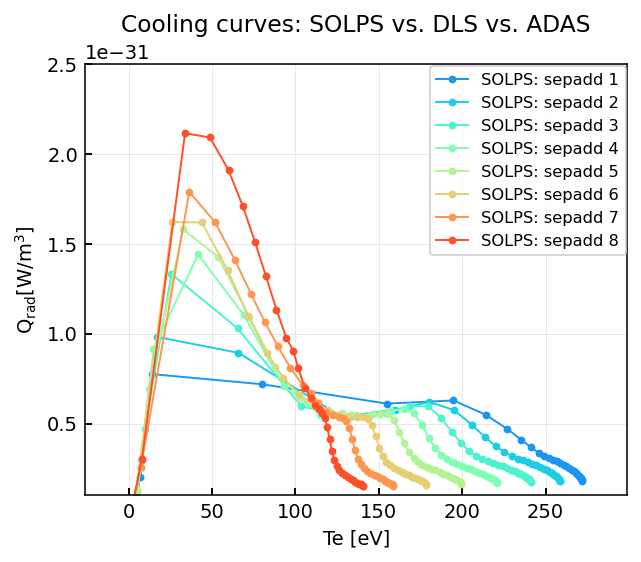

In [373]:
slc = store_slc["SPR45"]
rd2 = rd.sel(dim_electron_temp=slice(None, 500), dim_ne_tau=slice(1e16, None))

fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', 5)
colors = [cmap(x) for x in np.linspace(0,1, len(rd2["dim_ne_tau"]))]
ms = 3
marker = "X"


# for i, neTau in enumerate(rd2["dim_ne_tau"]):
#     data = rd2["equilibrium_Lz"].sel(dim_ne_tau = neTau, dim_electron_density=1e20, method="nearest")
#     data.plot(ax = ax, label = f"ADAS, ne*tau {neTau:.1e}", color = colors[i], lw = 1)
    

num_sepadds = 10
colors = [plt.cm.get_cmap("rainbow", num_sepadds+1)(x) for x in range(1,num_sepadds)]

for i in range(1,num_sepadds-1):

    solps = slc.get_1d_poloidal_data(["Te", "RAr", "fAr", "ne"], sepadd = i, region = "inner_lower")
    solps["Rar"] = abs(solps["RAr"])
    ax.plot(solps["Te"], solps["RAr"]/(solps["ne"]**2 * solps["fAr"]),  color = colors[i], lw = 1, ms = 3, marker = "o",label = f"SOLPS: sepadd {i}")
    

# ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_xlabel("Te [eV]")
ax.set_ylabel(f"$Q_{{rad}} [W/m^3]$")
ax.set_ylim(1e-32, 2.5e-31)
ax.legend(loc = "upper right", fontsize = "small")
ax.set_title("Cooling curves: SOLPS vs. DLS vs. ADAS")

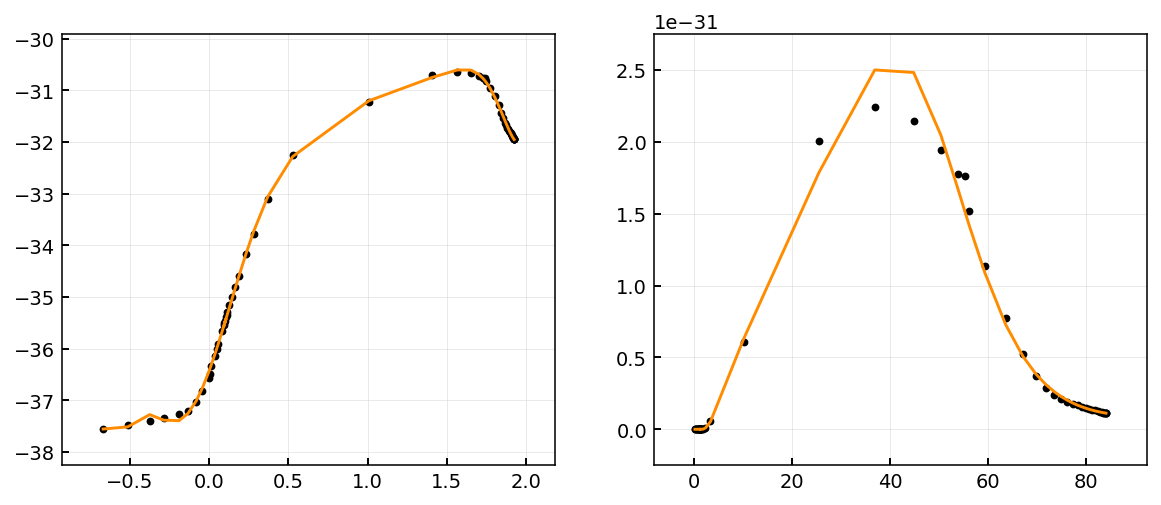

In [76]:
fig, axes = plt.subplots(1,2, figsize = (10,4))

x = solps["Te"]
y = solps["RAr"]/(solps["ne"]**2 * solps["fAr"])
logx = np.log10(x)
logy = np.log10(y)

axes[0].plot(logx, logy, c = "k", marker = "o", lw = 0, ms = ms, label = "SOLPS")
axes[1].plot(x, y, c = "k", marker = "o", lw = 0, ms = ms, label = "SOLPS")

coeffs = np.polyfit(logx, logy, 10)
fit_logy = np.polyval(coeffs, logx)

axes[0].plot(logx, fit_logy, c = "darkorange")
axes[1].plot(x, 10**(fit_logy), c = "darkorange")


In [77]:
coeffs

array([  5.28423922, -36.74959101,  92.67541517, -85.85515048,
       -26.72882023,  94.29311184, -28.39796852, -31.07978774,
        13.33243312,   8.43714703, -36.42474764])

In [188]:
impurity_name = "Ar"
main_ion_name = "D\+1"  ## WARNING: must escape out of + with \

dfimp = slc.species[slc.species["name"].str.contains(f"{impurity_name}\+")]

impurity_idx = list(dfimp.index)


nimp = 0

for i in impurity_idx:
    nimp += slc.bal["na"][:,:,i]
    slc.bal[f"n{impurity_name}"] = nimp
    
slc.bal[f"n{impurity_name}"] = nimp

slc.bal[f"f{impurity_name}"] = nimp / slc.bal["ne"]

In [48]:
solps["fAr"].mean()

0.04584387348589655

In [212]:
names = slc.species[slc.species["name"].str.contains(f"Ar\+")]["name"]
names = 

# solps = slc.get_1d_poloidal_data(["ne"] + names, sepadd = 1)

# fig, ax =plt.subplots()
# ax.plot(solps["Spar"], solps["fAr"])
# ax.set_xlabel("Lpar [m]")
# ax.set_ylabel("NAr+ / Ne")
# # ax.set_yscale("log")
# ax.set_title("Ar impurity fraction")


In [219]:
names.values.strip()

AttributeError: 'numpy.ndarray' object has no attribute 'strip'

In [176]:
main_ion_name = "D+1"
if "+" in main_ion_name:
    main_ion_name.replace("+", "\+")

main_ion_name

'D+1'

In [169]:
slc.species[slc.species["name"].str.contains("D\+1")]

name
1   D+1

(-7.0, -4.0)

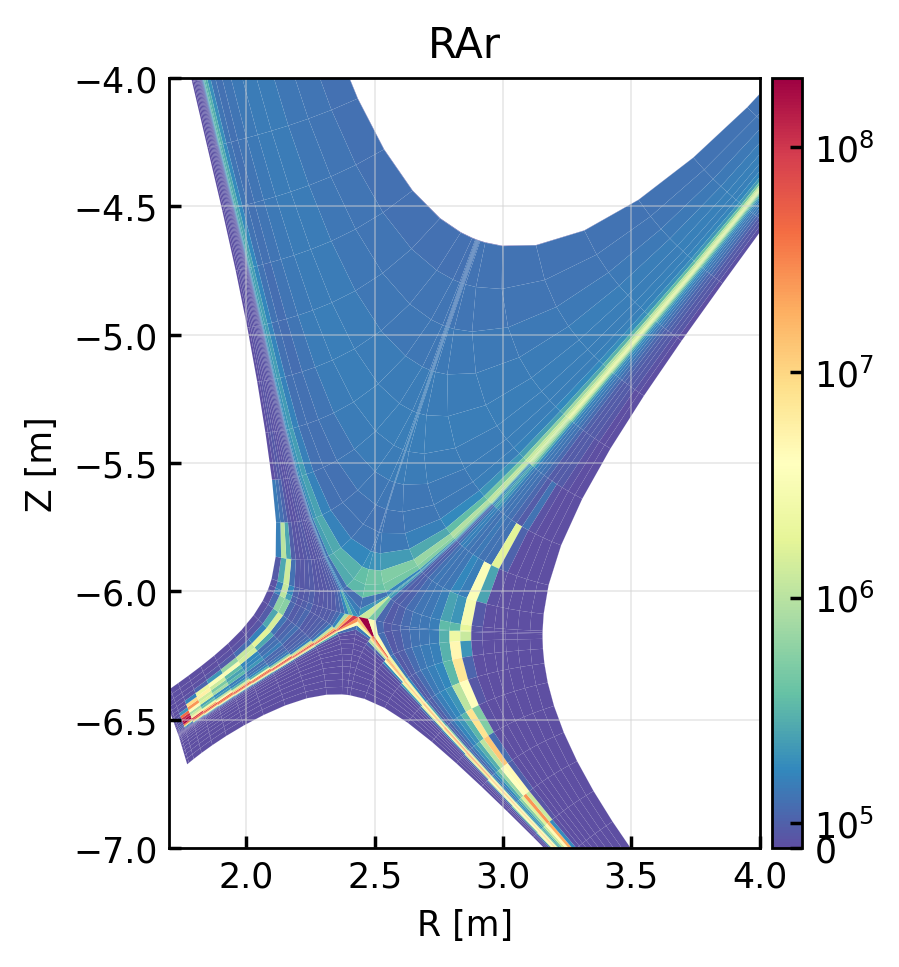

In [150]:
plt.close("all")
fig, ax = plt.subplots(dpi = 250)

slc.plot_2d("RAr", ax = ax, logscale = True, linthresh = 1e6, absolute = True, separatrix = False)
ax.set_xlim(1.7,4)
ax.set_ylim(-7, -4)

In [49]:
self = slc
sepadd = 1
region = "outer_lower"
params = ["R", "RAr"]

if type(params) == str:
    params = [params]

yind = self.g["sep"] + sepadd   # Ring index
omp = self.g["omp"]


if region == "outer_lower":
    selector = (slice(omp, None), yind)
else:
    raise Exception("Unrecognised region")

hx = self.bal["hx"][selector]
Btot = self.g["Btot"][selector]
Bpol = self.g["Bpol"][selector]

data = {}

for param in params:
    if param in self.bal:
        data[param] = self.bal[param]
    elif param in self.g:
        data[param] = self.g[param]
    else:
        raise ValueError(f"Parameter {param} not found")

df = pd.DataFrame()
df["spol"] = np.cumsum(hx)  # Poloidal distance

dspol = np.diff(df["spol"])
dspar = dspol * abs(Btot[1:] / Bpol[1:])
dspar = np.insert(dspar, 0, 0)
df["spar"] = np.cumsum(dspar)




In [38]:
self.g["Btot"].shape

(196, 34)

In [146]:
dlsTe[0]

0.0

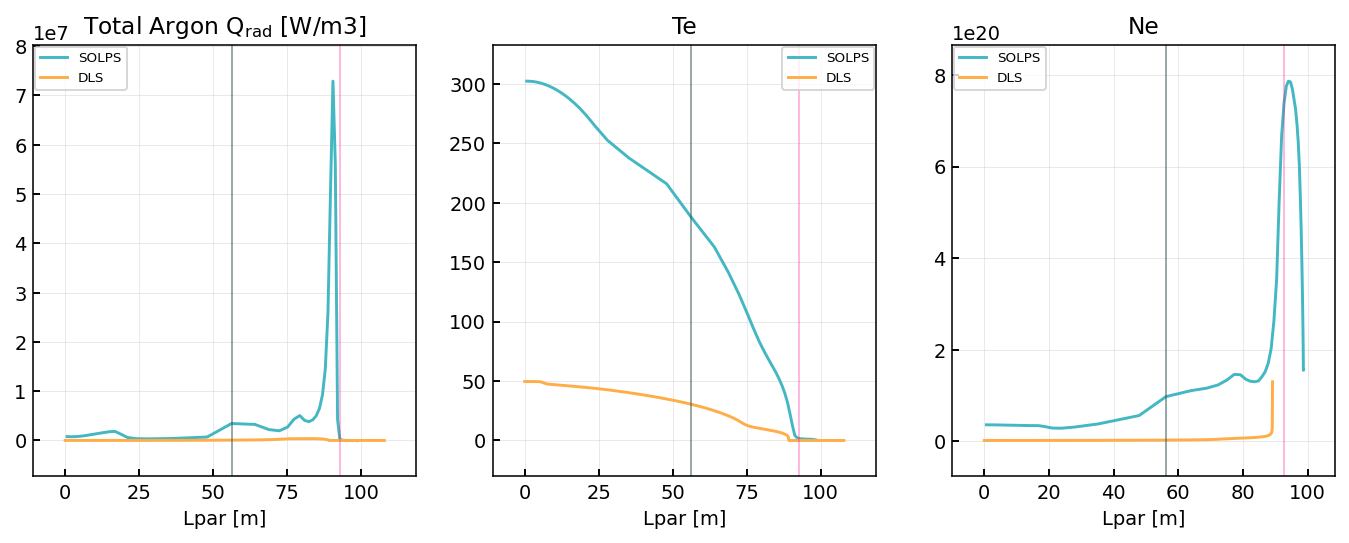

In [150]:

df = slc.get_1d_poloidal_data(["Te", "RAr", "ne"], sepadd = sepadd)
dfx = df[df["Xpoint"] == 1]

front_satisfied = (abs(df["RAr"]) < 0.001*abs(df["RAr"]).max()).abs()
front_satisfied = front_satisfied[::-1]
front_idx = 0
for i in front_satisfied.index[::-1]:
    if front_satisfied[i] == False:
        front_idx = i-1
        
dffront = df.loc[front_idx]

## DLS
dlsR = out["Rprofiles"][0]
dlsSpar = out["Sprofiles"][0][::-1]
# dlsSpar = dlsSpar[-1] - dlsSpar 
dlsTe = out["Tprofiles"][0]
dlsNe = out["cvar"][0] * dlsTe[-1] / dlsTe   ## Assuming cvar is ne

nfigs = 3
fsize = 4
fig, axes =plt.subplots(1,nfigs, figsize = (nfigs*fsize, fsize))

ax = axes[0]
ax.plot(df["spar"], df["RAr"]*-1, label = "SOLPS")
ax.plot(dlsSpar, dlsR, label = "DLS")
# ax.plot(dfx["spar"], dfx["RAr"]*-1, marker = "x", color = "red", ms = 5)

ax.set_title("Total Argon $Q_{rad}$ [W/m3]")

ax = axes[1]
ax.set_title("Te")
ax.plot(df["spar"], df["Te"], label = "SOLPS")
ax.plot(dlsSpar, dlsTe, label = "DLS")
# ax.plot(dfx["spar"], dfx["Te"]*-1, marker = "x", color = "red", ms = 5)

ax = axes[2]
ax.set_title("Ne")
ax.plot(df["spar"], df["ne"], label = "SOLPS")
ax.plot(dlsSpar, dlsNe, label = "DLS")
# ax.plot(dfx["spar"], dfx["RAr"]*-1, marker = "x", color = "red", ms = 5)

for ax in axes:
    ax.set_xlabel("Lpar [m]")
    ylims = ax.get_ylim()
    ax.vlines(dfx["spar"], *ylims, color = "darkslategrey", ls = "-", alpha = 0.5, lw = 1)
    ax.vlines(dffront["spar"], *ylims, color = "deeppink", ls = "-", alpha = 0.3, lw = 1)
    ax.set_ylim(ylims)
    ax.legend(fontsize = "x-small")

# fig.tight_layout()


In [132]:
df["spar"].iloc[-1] - dffront["spar"]

5.994236419660041

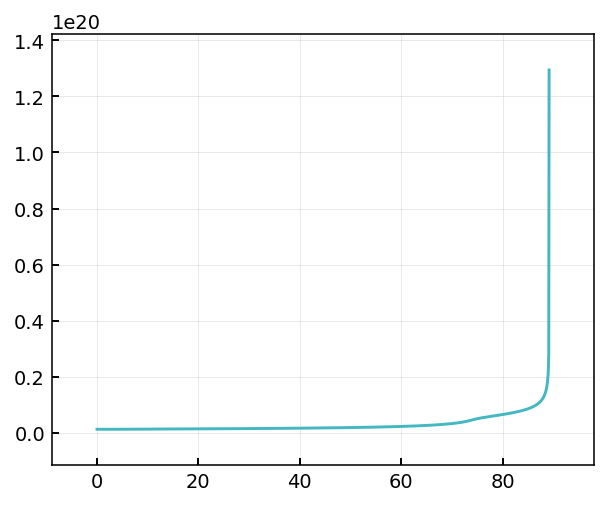

In [148]:
fig, ax = plt.subplots()
ax.plot(dlsSpar, dlsNe)
# ax.set_yscale("log")

In [53]:
R = self.g["R"][selector]
np.argmin(abs(R - R.min()))

25

Text(0.5, 1.0, 'Poloidal distribution of Ar radiation')

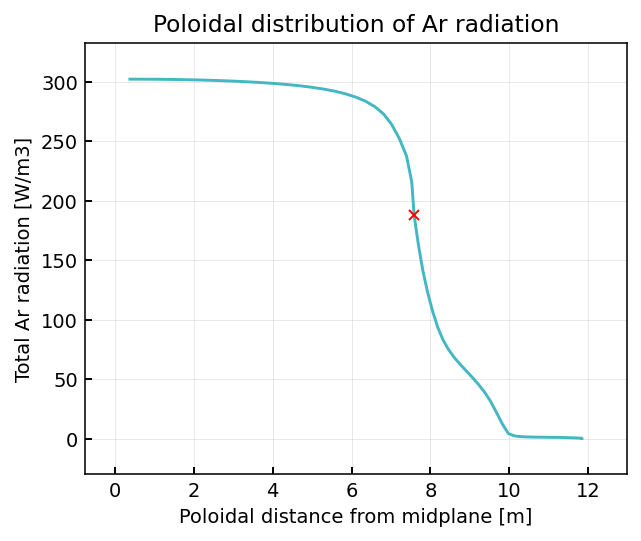

In [135]:
sepadd = 1
df = slc.get_1d_poloidal_data(["Te"], sepadd = sepadd)

dfr = slc.get_1d_poloidal_data("R", sepadd = sepadd)
idxmin = dfr[dfr["R"] == dfr["R"].min()].index

fig, ax =plt.subplots()
ax.plot(df["dist"], df["Te"])

ax.plot(dfr["dist"][idxmin], df["Te"][idxmin], marker = "x", color = "red", ms = 5)
ax.set_xlabel("Poloidal distance from midplane [m]")
ax.set_ylabel("Total Ar radiation [W/m3]")
ax.set_title("Poloidal distribution of Ar radiation")


In [80]:
self = slc
sepadd = 0
region = "outer_lower"
param = "RAr"

yind = self.g["sep"] + sepadd   # Ring index
omp = self.g["omp"]
hx = self.bal["hx"]

if region == "outer_lower":
    selector = (yind, slice(omp, None))
else:
    raise Exception("Unrecognised region")


df = pd.DataFrame()
df["dist"] = np.cumsum(hx[selector])  # Poloidal distance
# df["R"] = self.g["R"][selector[::-1]]
# df["Z"] = self.g["Z"][selector[::-1]]
df[param] = self.bal[param][selector]

In [84]:
selector

(15, slice(134, None, None))

In [88]:
omp

134

In [89]:
hx[slice(omp,None), yind].shape

(62,)

In [ ]:
yind = self.g["sep"] + sepadd   # Ring index
        omp = self.g["omp"]
        hx = self.bal["hx"]
        
        if region == "outer_lower":
            selector = (yind, slice(omp, None))
        else:
            raise Exception("Unrecognised region")
        
        
        df = pd.DataFrame()
        df["dist"] = np.cumsum(hx[selector])  # Poloidal distance
        # df["R"] = self.g["R"][selector[::-1]]
        # df["Z"] = self.g["Z"][selector[::-1]]
        df[param] = self.bal[param][selector]

# Extract impurity fraction

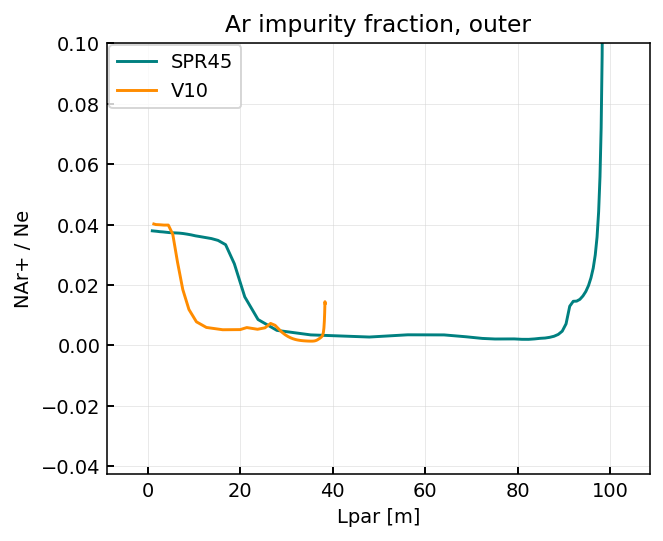

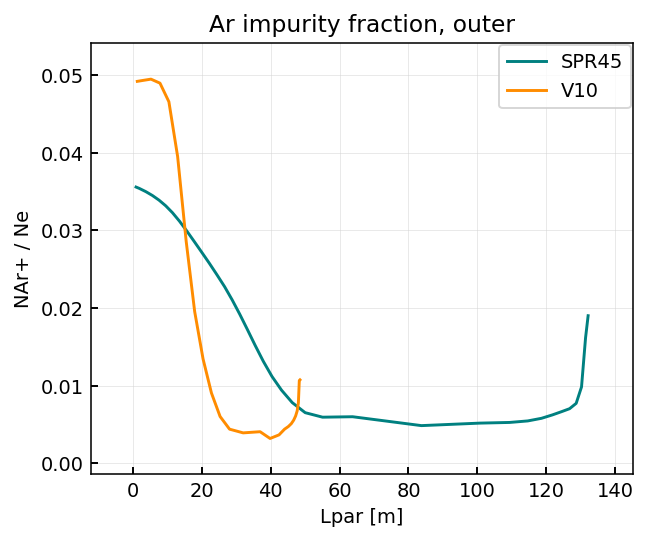

In [360]:
fig, ax = plt.subplots()
for case in store_slc:
    slc = store_slc[case]
    solps = slc.get_1d_poloidal_data(["fAr"], sepadd = 1, region = "outer_lower")
    ax.plot(solps["Spar"], solps["fAr"], label = case)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("NAr+ / Ne")
# ax.set_yscale("log")
ax.set_title("Ar impurity fraction, outer")
ax.legend()
ax.set_ylim(None, 0.1)

fig, ax = plt.subplots()
for case in store_slc:
    slc = store_slc[case]
    solps = slc.get_1d_poloidal_data(["fAr"], sepadd = 1, region = "inner_lower")
    ax.plot(solps["Spar"], solps["fAr"], label = case)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("NAr+ / Ne")
# ax.set_yscale("log")
ax.set_title("Ar impurity fraction, outer")
ax.legend()


# 2D Plot

Text(0, 0.5, 'Z [m]')

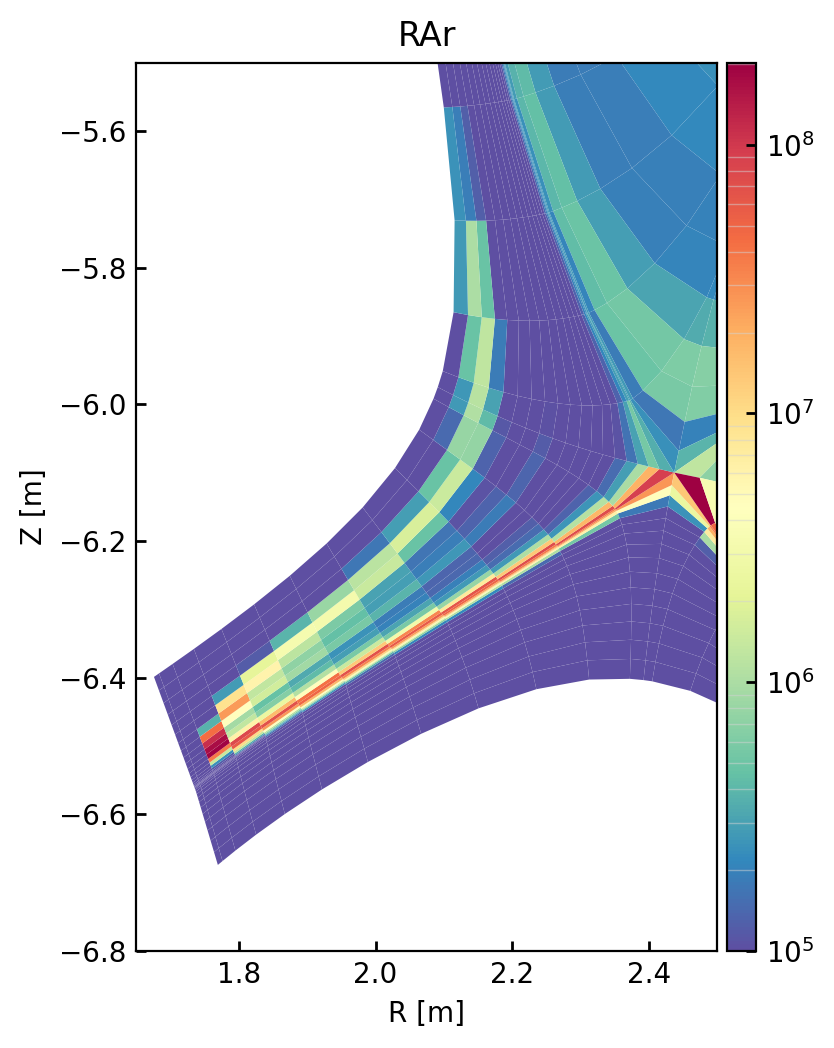

In [195]:
slc = store_slc["SPR45"]

fig, ax = plt.subplots(dpi = 200, figsize = (4,6), sharey = True)

slc.plot_2d(param = "RAr",  ax = ax, 
            linewidth = 0, antialias = True, grid_only = False, vmax = None, vmin = 1e5, logscale = True, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)


ax.grid(False)

# SPR45
# ax.set_xlim(1.5, 6.0)
# ax.set_ylim(-9, -4)

# SPR45 inner
ax.set_xlim(1.65, 2.5)
ax.set_ylim(-6.8, -5.5)

# V10
# ax.set_xlim(1.0, 4.5)
# ax.set_ylim(-7, -3)

ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

In [ ]:
self = wall_details(
    # gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5.geqdsk",
    gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5-LATEST.geqdsk",
    wfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\SPR45.txt",
    monoblock = {"g":0.5e-3,"l":2e-3,"h":0.3e-3,"p":0.028},
    debug = True,
    fig = fig,
    ax = ax,
    custom_plot = True
)

Text(0, 0.5, 'Z [m]')

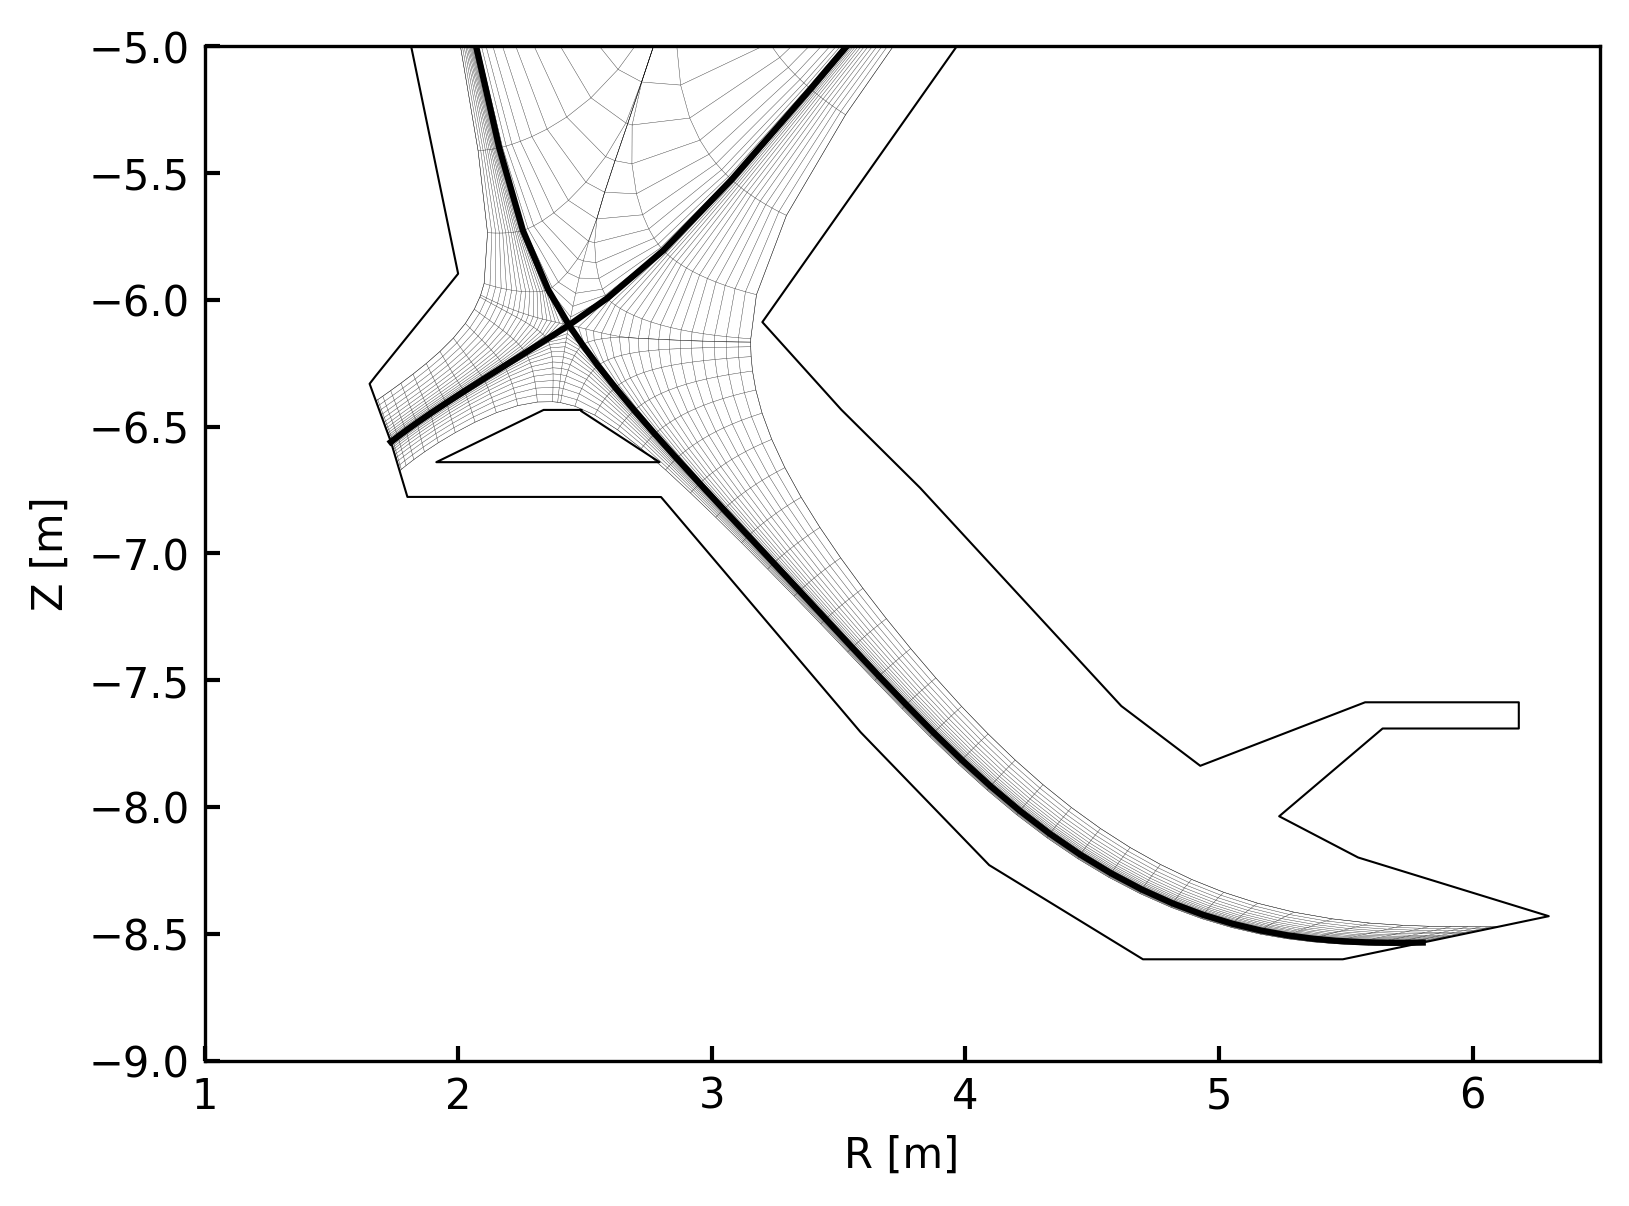

In [11]:
rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
domeR = np.array([2486,2337,1914,2794,2486])
domeZ = np.array([6434,6434,6640,6640,6439])

fig, ax = plt.subplots(dpi = 300, figsize = (6,8), sharey = True)

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
slc.plot_2d(param = f"",  ax = ax, 
            linewidth = 0.1, antialias = True, grid_only = True, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False, alpha = 0.5)


ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = 0.5)
ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = 0.5)
ax.set_aspect("equal")
ax.set_xlim(1.0, 6.5)
ax.grid(False)
ax.set_ylim(-9, -5)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

# Improve SOLPS parallel geometry m

## Checker

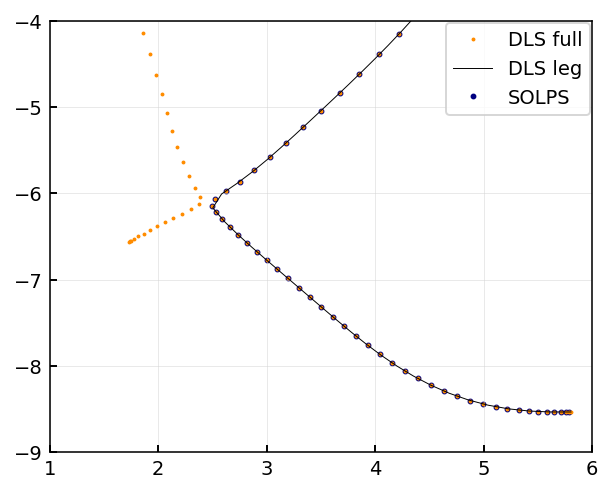

In [116]:
plt.close("all")
out = unpackConfigurationMK(File = os.path.join(balance_paths["SPR45"], "balance.nc"), Type = "ol", sepadd=1, resolution = 60, diagnostic_plot = False)
df = slc.get_1d_poloidal_data(["Btot", "Bpol", "R", "Z"], sepadd = sepadd)

fig, ax = plt.subplots()
ax.plot(out["full_R"], out["full_Z"], c = "darkorange", marker = "o", lw = 0, ms = 1, label = "DLS full")
ax.plot(out["R"], out["Z"], c= "k", marker = "o", lw = 0.5, ms = 0, label = "DLS leg")
ax.plot(df["R"], df["Z"], c = "navy", marker = "o", ms = 2, lw = 0, label = "SOLPS", zorder = 0)
ax.set_xlim(1,6)
ax.set_ylim(-9, -4)
ax.legend()

## old

In [413]:
params = ["Btot"]
sepadd = 4
region = "outer_lower"

self = store_slc["SPR45"]

if type(params) == str:
    params = [params]

yind = self.g["sep"] + sepadd   # Ring index
omp = self.g["omp"]
imp = self.g["imp"]

## NOTE: Must extend to one cell beyond midplane
if region == "outer_lower":
    selector = (slice(omp, -2), yind)
elif region == "inner_lower":
    selector = (slice(1, imp), yind)
else:
    raise Exception("Unrecognised region")

Btot = self.g["Btot"][selector]
Bpol = self.g["Bpol"][selector]
R = self.g["R"][selector]
Z = self.g["Z"][selector]
hx = self.g["hx"][selector]
# dSpol = returnll(R[::-1], Z[::-1])  # cell widths between cell centres not boundaries
# midplane_correction = hx[0]/2  # OMP is at cell boundary, data at centres

df = pd.DataFrame()
df["Spol"] = np.cumsum(hx)
df["Btot"] = Btot
df["Bpol"] = Bpol
df["R"] = R
df["Z"] = Z

df["Spol"] -= df["Spol"].iloc[0]   # Now 0 is cell centre before midplane

## Interpolate onto Z = 0
for param in df.columns.drop("Z"):
    interp = scipy.interpolate.interp1d(df["Z"], df[param], kind = "linear")
    df.loc[0, param] = interp(0)
df.loc[0,"Z"] = 0  
    
df["Spol"] -= df["Spol"].iloc[0]   # Now 0 is at Z = 0

dspar = df["Spol"].diff() * abs(df["Btot"] / df["Bpol"])
df["Spar"] = np.cumsum(dspar)

## Interpolate onto higher resolution
res = 300
dfi = pd.DataFrame()
dfi["Spol"] = np.linspace(df["Spol"].iloc[0], df["Spol"].iloc[-1], res)

for param in df.columns.drop("Spol"):
    interp = scipy.interpolate.interp1d(df["Spol"], df[param], kind = "cubic")
    dfi[param] = interp(dfi["Spol"])
    
dspar = dfi["Spol"].diff() * abs(dfi["Btot"] / dfi["Bpol"])
dfi["Spar"] = np.cumsum(dspar)
dfi.loc[0, "Spar"] = 0


In [321]:
len(df)

60

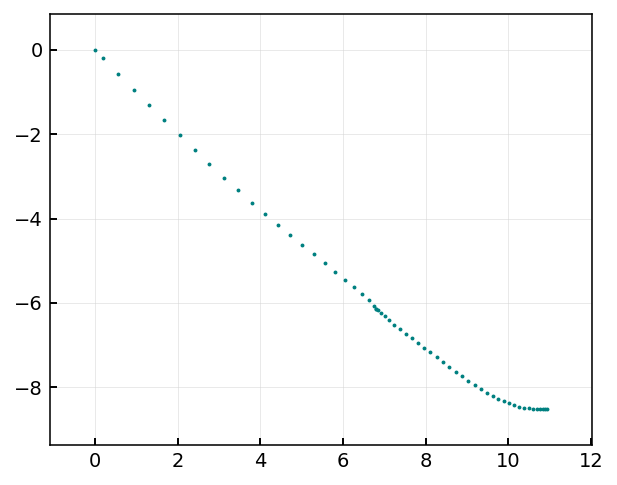

In [320]:
fig, ax = plt.subplots()
ax.plot(df["Spol"], df["Z"], lw = 0, marker = "o", ms = 1)

In [556]:
Spol_midplane = hx[0]/2  # Dist between first cell centre and boundary

res = 500

## Interpolate to higher resolution
dfi = pd.DataFrame()
dfstart = df.iloc[0,:]
dfi["Spol"] = np.linspace(df["Spol"].iloc[0], df["Spol"].iloc[-1], res)

for param in df.drop(["Spol"], axis = 1):
    interp = interpolate.interp1d(df["Spol"], df[param], kind = "cubic")
    dfi[param] = interp(dfi["Spol"])
    
dspar = dfi["Spol"].diff() * abs(dfi["Btot"] / dfi["Bpol"])
dfi["Spar"] = np.cumsum(dspar)
    # dfi.insert(1, "Spar", Spar
    
case = "SPR45"

nfigs = 3
fsize = 4
fig, axes =plt.subplots(1,nfigs, figsize = (nfigs*fsize, fsize))

d = eqb[case]["ol"][sepadd].copy()
slc = store_slc[case]
# df = slc.get_1d_poloidal_data(["Btot", "R", "Z"], sepadd = 1)
# df = dfi

df["Spol"] = df["Spol"].max() - df["Spol"][::-1]
df["Spar"] = df["Spar"].max() - df["Spar"][::-1]

style_dls = dict(lw = 3, alpha = 0.5)
style_solps = dict()
ax = axes[0]
ax.set_title("Btot vs. Spol")
ax.plot(d["Spol"], d["Btot"], label = "DLS", **style_dls)
ax.plot(df["Spol"], df["Btot"], label = "SOLPS", **style_solps)
# ax.plot(dfi["Spol"], dfi["Btot"], label = "SOLPS, interp")

ax = axes[1]
ax.set_title("Btot vs. Spar")
ax.plot(d["S"], d["Btot"], label = "DLS", **style_dls)
ax.plot(df["Spar"], df["Btot"], label = "SOLPS", **style_solps)
# ax.plot(dfi["Spar"], dfi["Btot"], label = "SOLPS, interp")

ax = axes[2]
ax.set_title("RZ")
ax.plot(d["R"], d["Z"], label = "DLS", **style_dls)
ax.plot(df["R"], df["Z"], label = "SOLPS", **style_solps)

# ax.plot(dfi["R"], dfi["Z"], label = "SOLPS, interp")

for ax in axes:
    ax.legend()

KeyError: 'Btot'

In [430]:
%matplotlib widget

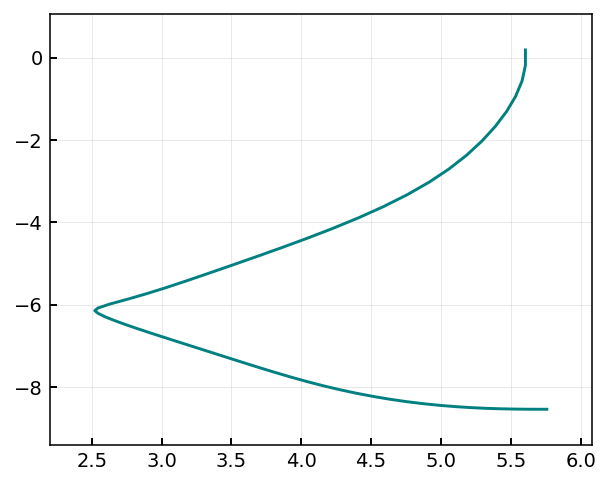

In [425]:
plt.plot(solps["R"], solps["Z"])
plt.show()

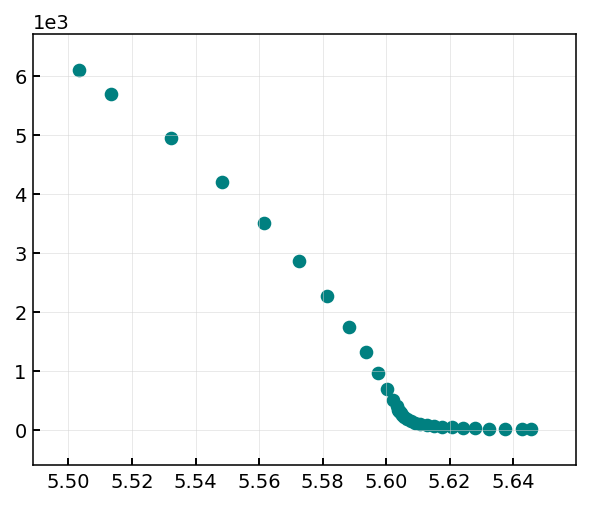

In [439]:
df = slc.get_1d_radial_data(["Ne", "Te"], region = "omp")

fig, ax = plt.subplots()
ax.scatter(df["R"], df["Te"])

In [176]:
%matplotlib widget

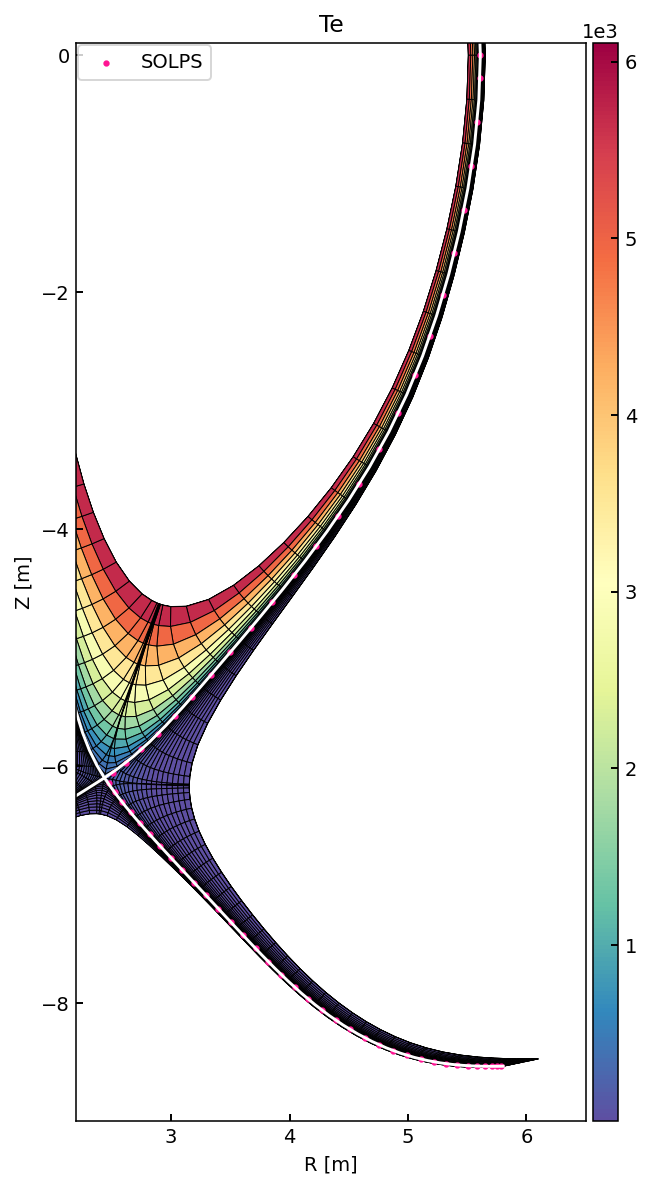

In [179]:
plt.close("all")

sepadd = 0

fig, ax = plt.subplots(figsize = (5,10))

dls = unpackConfigurationMK(File = os.path.join(balance_paths[case], "balance.nc"), Type = "ol", sepadd=sepadd, resolution = 100, diagnostic_plot = False)
solps = slc.get_1d_poloidal_data(["Btot", "R", "Z"], sepadd = sepadd, region = "outer_lower")

slc.plot_2d("Te", ax = ax, linewidth = 0.5)

# ax.scatter(dls["R"], dls["Z"], c = "yellow", s = 3, label = "DLS")
ax.scatter(solps["R"], solps["Z"], c = "deeppink", s = 5, label = "SOLPS")
ax.set_xlim(2.2, 6.5)
ax.set_ylim(-9, 0.1)
ax.legend()
ax.grid(False)